<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you load this notebook by clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement autoregressive models and run it on various datasets. Oftentime you will run it on two datasets (dataset 1 and dataset 2). In these cases, the expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

There is a lot of freedom in this homework to design write and design your own models. Hyperparameters are given as a guide to show what worked for us, but feel free to explore and use what you find is best!

Run the cells below to download and load up the starter code.

In [1]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git 
# !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
# !pip install ./deepul

In [1]:
import numpy as np
import copy
# import jax.numpy as np

from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
    # Q3
    
    q3ab_save_results,
    q3c_save_results,
    # Q4
    q4a_save_results,
    q4b_save_results,
    # Q5
    visualize_q5_data,
    q5a_save_results,
    # Q6
    visualize_q6_data,
    q6a_save_results,
)

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


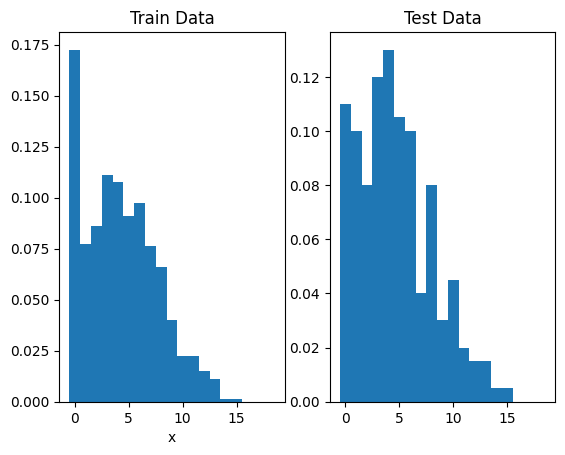

Dataset 2


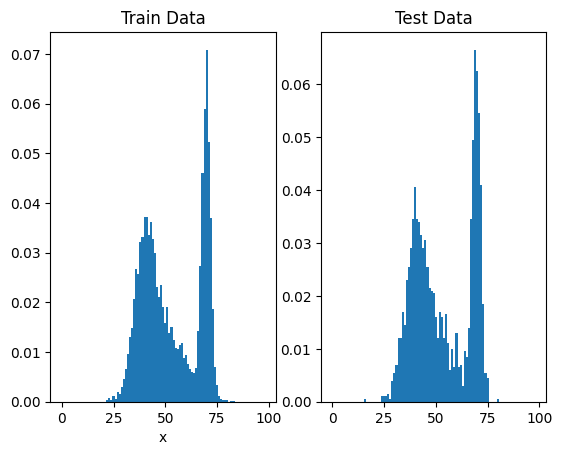

In [5]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^{d}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [6]:

def softmax_probs(theta):
    """Computes all softmax probabilities for given theta."""
    theta_shifted = theta - np.max(theta)  # Stability trick
    exp_theta = np.exp(theta_shifted)
    return exp_theta / np.sum(exp_theta)
def q1_a(train_data, test_data, d, dset_id):
    """
    Optimized version of q1_a for better performance
    """
    train_losses = []
    test_losses = []
    theta = np.zeros(d, dtype=float)
    y = np.bincount(train_data, minlength=d) / len(train_data)
    
    print("train_data shape: ", train_data.shape)
    print("d: ", d)
    print("dset_id", dset_id)

    # Hyperparameters
    epochs = 200000
    learning_rate = 0.1
    
    # Calculate test loss only periodically
    eval_interval = 10
    
    # Pre-allocate arrays
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        probs = softmax_probs(theta)
        nll = -np.mean(np.log(probs[train_data]))
        d_nll = probs - y
        
        theta -= learning_rate * d_nll
        train_losses[epoch] = nll
        
        # Calculate test loss only periodically
        if epoch % eval_interval == 0:
            t_nll = -np.mean(np.log(probs[test_data]))
            test_losses[epoch] = t_nll
        elif epoch > 0:  # Copy the previous value for non-evaluated epochs
            test_losses[epoch] = test_losses[epoch-1]
    
    distribution = softmax_probs(theta)
    return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



train_data shape:  (800,)
d:  20
dset_id 1


Final Test Loss: 2.5434


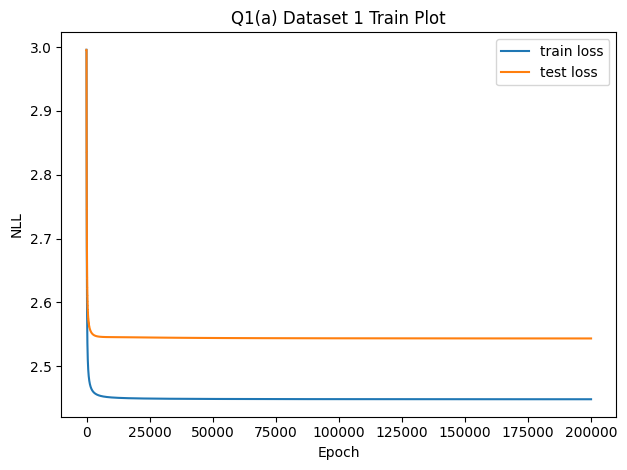

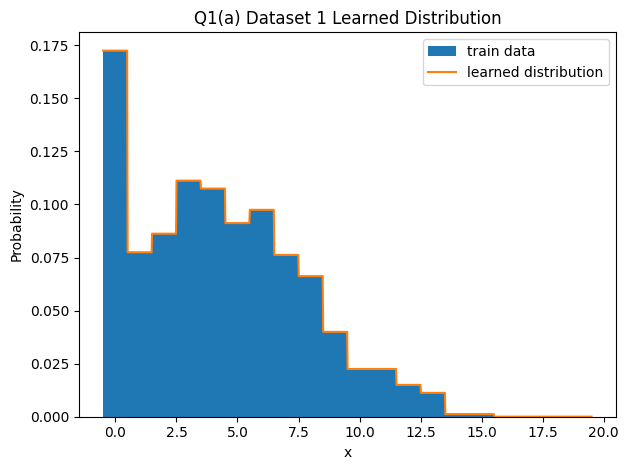

In [7]:
q1_save_results(1, 'a', q1_a)

train_data shape:  (8000,)
d:  100
dset_id 2
Final Test Loss: 3.6897


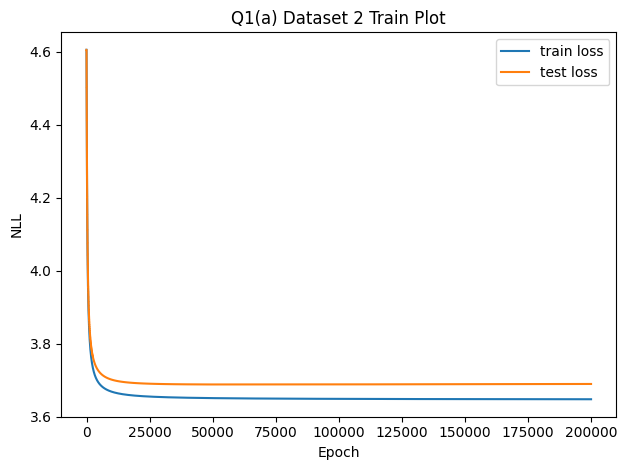

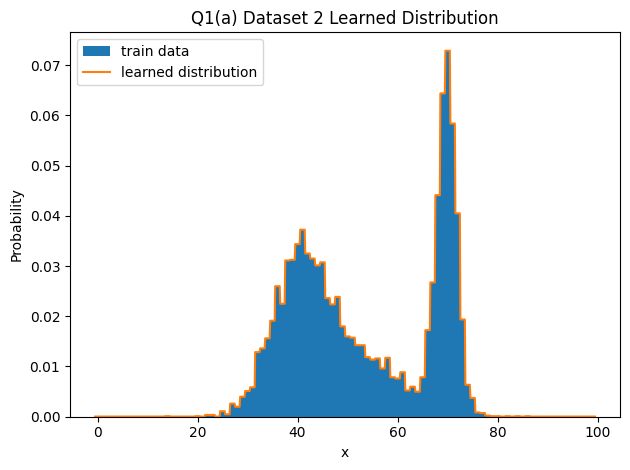

In [8]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class MixtureOfLogistics(nn.Module):
    """Mixture of Logistics distribution model for discrete data."""
    
    def __init__(self, d, n_mix=4):
        """
        Initialize the Mixture of Logistics model.
        
        Args:
            d: Number of possible discrete values (0 to d-1)
            n_mix: Number of mixture components
        """
        super().__init__()
        self.d = d
        self.n_mix = n_mix
        
        # TODO: Initialize model parameters
        # 1. Mixture weights (logit_probs)
        # 2. Component means (means)
        # 3. Component scales (log_scales)
        self.logit_probs = nn.Parameter(torch.zeros(n_mix)) # shape (n_mix,)
        init_means = torch.linspace(0,d-1,n_mix) + torch.randn(n_mix)*0.1  #shape (n_mix,)
        self.means = nn.Parameter(torch.clamp(init_means,0,d-1))
        self.log_scales = nn.Parameter(torch.ones(n_mix)*0.5) # shape (n_mix,1)
        
    
    def forward(self, x):
        """
        Compute the log probability of each value in x.
        
        Args:
            x: tensor of shape (batch_size,) containing integers in {0, ..., d-1}
            
        Returns:
            tensor of shape (batch_size,) containing log probabilities
        """
        # TODO: Implement forward pass
        # 1. Get mixture weights using softmax on logit_probs
        # 2. Ensure scales are positive (e.g., using softplus)
        # 3. Calculate CDF at x+0.5 and x-0.5 for each component
        # 4. Handle edge cases (x=0 and x=d-1)
        # 5. Compute probabilities from CDF differences
        # 6. Weight by mixture weights and sum
        # 7. Return log probabilities
        probs = torch.softmax(self.logit_probs, dim=0)  # n_mix
        probs = probs.unsqueeze(0)  # 1, n_mix

        scales = nn.functional.softplus(self.log_scales)  # n_mix 
        scales = scales.unsqueeze(0)  # 1, n_mix

        x = x.unsqueeze(1)  # batch_size,1
        x_float = x.float()
        first_term = torch.sigmoid((x_float + 0.5 - self.means) / scales)
        second_term = torch.sigmoid((x_float - 0.5 - self.means) / scales)

        # Handle edge cases
        is_d_minus_one = (x == self.d - 1)
        is_zero = (x == 0)
        first_term = torch.where(is_d_minus_one, torch.ones_like(first_term), first_term)
        second_term = torch.where(is_zero, torch.zeros_like(second_term), second_term)

        # Calculate component probabilities
        component_probs = first_term - second_term  # batch_size, n_mix
        probabilities = probs * component_probs  # batch_size, n_mix
        probabilities = probabilities.sum(dim=1)  # batch_size

        # Return log probabilities
        return torch.log(probabilities + 1e-10)
    
    def get_distribution(self):
        """
        Returns the probability distribution over all possible values.
        
        Returns:
            numpy array of shape (d,) containing probabilities
        """
        device = next(self.parameters()).device
        x = torch.arange(self.d, device=device)
        with torch.no_grad():
            log_probs = self.forward(x)
            probs = torch.exp(log_probs)
            return (probs / torch.sum(probs)).cpu().numpy()


def q1_b(train_data, test_data, d, dset_id):
    """
    Train a mixture of logistics model on discrete data.
    """
    # Set random seed and device
    torch.manual_seed(42)
    np.random.seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Convert data to tensors
    train_tensor = torch.tensor(train_data, dtype=torch.long, device=device)
    test_tensor = torch.tensor(test_data, dtype=torch.long, device=device)
    
    # Create dataset and dataloader
    train_dataset = TensorDataset(train_tensor)
    test_dataset = TensorDataset(test_tensor)
    # Set hyperparameters based on dataset ID
    hyperparams = {
        1: {"batch_size": 800, "lr": 0.005, "num_epochs": 10000}, 
        2: {"batch_size": 800, "lr": 0.001, "num_epochs": 10000}
    }[dset_id]
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=hyperparams["batch_size"], 
        shuffle=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=hyperparams["batch_size"],
        shuffle=False
    )
    train_losses = np.zeros(hyperparams["num_epochs"])
    test_losses = np.zeros(hyperparams["num_epochs"])
    # Initialize model and optimizer
    model = MixtureOfLogistics(d, n_mix=4).to(device)
    optimizer = optim.Adam(model.parameters(), lr=hyperparams["lr"])
    
    # TODO: Implement training loop
    # 1. Track training and test losses
    # 2. For each epoch:
    #    a. Train the model on batches
    #    b. Compute and record loss
    #    c. Evaluate on test set
    for epoch in range(hyperparams["num_epochs"]):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            x = batch[0].to(device)
            log_probs = model(x)
            nll = -log_probs.mean()
            nll.backward()
            
            optimizer.step()
            train_loss += nll.item()
        train_losses[epoch] = train_loss / len(train_loader)
        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0].to(device)
                log_probs = model(x)
                nll = -log_probs.mean()
                test_loss += nll.item()
        test_losses[epoch] = test_loss / len(test_loader)
    # Get final model probabilities
    model.eval()
    model_probs = model.get_distribution()
    print("len(model_probs)", len(model_probs))
    # Return placeholder values for now
    return train_losses, test_losses, model_probs

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



len(model_probs) 20
Final Test Loss: 2.5499


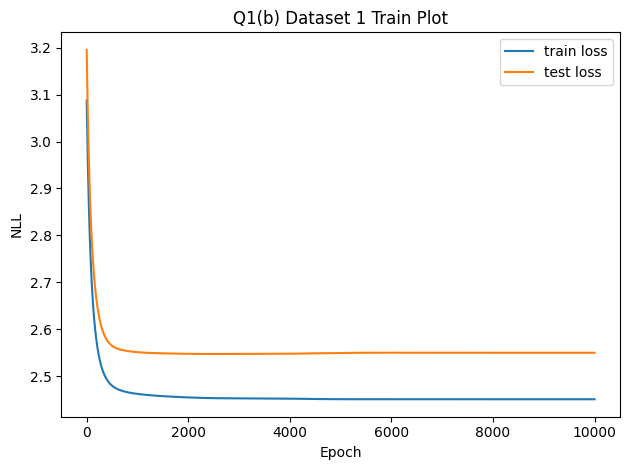

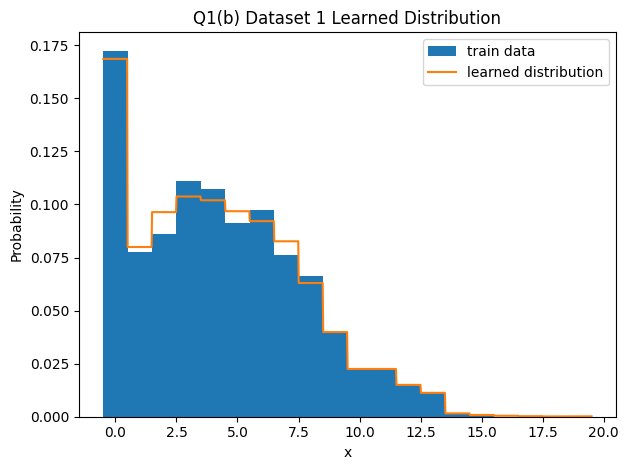

In [10]:
q1_save_results(1, 'b', q1_b)

len(model_probs) 100
Final Test Loss: 4.0082


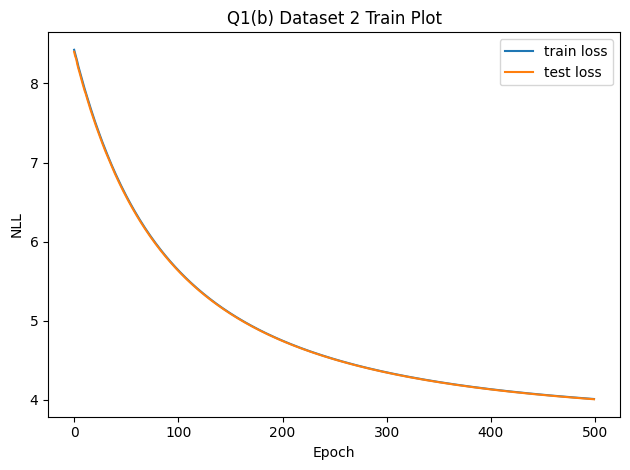

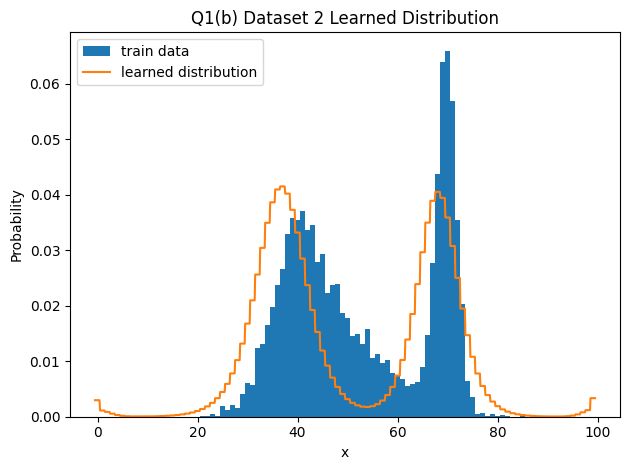

In [11]:
q1_save_results(2, 'b', q1_b)

# Question 2 PixelCNNs

Now, you will train more powerful PixelCNN models on the shapes dataset and MNIST. In addition, we will extend to modeling colored datasets.

Run the cell below to visualize the two datasets binary datasets

data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
samples shape:  (100, 20, 20, 1)


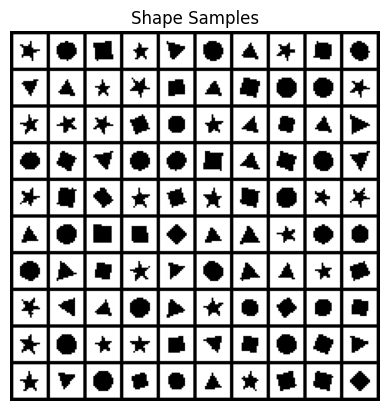

data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
samples shape:  (100, 28, 28, 1)


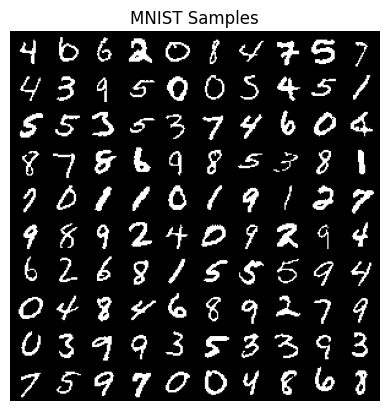

In [5]:
visualize_q2a_data(1)
visualize_q2a_data(2)

## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

Checkout the Paper for more details: https://arxiv.org/abs/1601.06759

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm

class MaskedConv2d(nn.Conv2d):
    """
    Implementation of a masked convolution layer for PixelCNN.
    Masks can be of type 'A' or 'B'.
    """
    def __init__(self, in_channels, out_channels, kernel_size, mask_type='A', padding='same', **kwargs):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, padding=padding, **kwargs)
        self.register_buffer('mask', torch.ones_like(self.weight))
        self.mask_type = mask_type
        
        # Create mask
        h, w = kernel_size, kernel_size
        if isinstance(kernel_size, int):
            h, w = kernel_size, kernel_size
            
        center_h, center_w = h // 2, w // 2
        
        # For all spatial locations
        for i in range(h):
            for j in range(w):
                # Mask out future pixels (below and to the right)
                if (i > center_h) or (i == center_h and j > center_w):
                    self.mask[:, :, i, j] = 0
                    
                # For mask type A, also mask out the center pixel
                if mask_type == 'A' and i == center_h and j == center_w:
                    self.mask[:, :, i, j] = 0
    
    def forward(self, x):
        # Apply the mask to weights
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

class PixelCNN(nn.Module):
    """
    PixelCNN model for binary image generation.
    As recommended in the assignment:
    - One 7x7 masked type A convolution
    - Five 7x7 masked type B convolutions
    - Two 1x1 masked type B convolutions
    - ReLU nonlinearities in-between
    - 64 convolutional filters
    """
    def __init__(self, in_channels=1, hidden_dim=64):
        super(PixelCNN, self).__init__()
        
        # Initial masked convolutional layer of type A
        self.conv_a = MaskedConv2d(in_channels, hidden_dim, kernel_size=7, mask_type='A', padding='same')
        
        # Stack of masked convolutional layers of type B
        self.conv_b_stack = nn.ModuleList([
            MaskedConv2d(hidden_dim, hidden_dim, kernel_size=7, mask_type='B', padding='same')
            for _ in range(5)
        ])
        
        # Final 1x1 convolutions
        self.conv_1x1_stack = nn.ModuleList([
            MaskedConv2d(hidden_dim, hidden_dim, kernel_size=1, mask_type='B', padding='same')
            for _ in range(2)
        ])
        
        # Output layer: 1 channel for binary output (will apply sigmoid later)
        self.output_conv = MaskedConv2d(hidden_dim, 1, kernel_size=1, mask_type='B', padding='same')
        
    def forward(self, x):
        # Apply first mask A convolution
        x = F.relu(self.conv_a(x))
        
        # Apply mask B convolutions with ReLU
        for conv_b in self.conv_b_stack:
            x = F.relu(conv_b(x))
            
        # Apply 1x1 convolutions with ReLU
        for conv_1x1 in self.conv_1x1_stack:
            x = F.relu(conv_1x1(x))
            
        # Final output layer (returns logits)
        x = self.output_conv(x)
        
        return x

def sample_from_model(model, image_shape, device, num_samples=100):
    """
    Sample images from the trained model using ancestral sampling.
    """
    model.eval()
    samples = torch.zeros((num_samples, 1, image_shape[0], image_shape[1]), device=device)
    
    with torch.no_grad():
        # Generate each pixel sequentially
        for i in range(image_shape[0]):
            for j in range(image_shape[1]):
                # Get the model's prediction
                logits = model(samples)[:, :, i, j]
                # Convert logits to probabilities
                probs = torch.sigmoid(logits)
                # Sample from Bernoulli distribution
                samples[:, :, i, j] = torch.bernoulli(probs)
    
    return samples.cpu().numpy().transpose(0, 2, 3, 1)

def binary_cross_entropy_loss(logits, targets):
    """
    Compute binary cross entropy loss from logits.
    """
    return F.binary_cross_entropy_with_logits(logits, targets)

def negative_log_likelihood(logits, targets):
    """
    Compute negative log likelihood in nats per dimension.
    """
    batch_size = targets.size(0)
    n_dims = targets.size(1) * targets.size(2) * targets.size(3)
    
    # Compute binary cross entropy (already in log scale)
    bce = binary_cross_entropy_loss(logits, targets)
    
    # Convert to nats (from bits) and normalize by dimensions
    # No need for conversion as PyTorch already uses natural log
    nll = bce * n_dims
    
    return nll

In [7]:
def q2_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Hyperparameters
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 10
    
    # Convert data to PyTorch tensors and scale to [-1, 1]
    train_data = torch.from_numpy(train_data).float().permute(0, 3, 1, 2).to(device)
    test_data = torch.from_numpy(test_data).float().permute(0, 3, 1, 2).to(device)
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    # Initialize model, optimizer
    model = PixelCNN(in_channels=1, hidden_dim=64).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Lists to store metrics
    train_losses = []
    test_losses = []
    
    # Initial test loss
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            outputs = model(data)
            loss = negative_log_likelihood(outputs, data)
            total_test_loss += loss.item()
    initial_test_loss = total_test_loss / len(test_loader)
    test_losses.append(initial_test_loss)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, data in enumerate(progress_bar):
            optimizer.zero_grad()
            outputs = model(data)
            loss = binary_cross_entropy_loss(outputs, data)
            loss.backward()
            optimizer.step()
            
            # Track the average NLL per dimension
            nll = negative_log_likelihood(outputs, data)
            train_losses.append(nll.item())
            
            progress_bar.set_postfix({'Loss': nll.item()})
        
        # Evaluate on test set after each epoch
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for data in test_loader:
                outputs = model(data)
                loss = negative_log_likelihood(outputs, data)
                total_test_loss += loss.item()
        epoch_test_loss = total_test_loss / len(test_loader)
        test_losses.append(epoch_test_loss)
        
        print(f'Epoch {epoch+1}: Test Loss: {epoch_test_loss:.6f}')
    
    # Generate samples
    samples = sample_from_model(model, image_shape, device, num_samples=100)
    samples = (samples > 0.5).astype(np.uint8)  # Convert probabilities to binary
    
    return np.array(train_losses), np.array(test_losses), samples

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data


Epoch 1/10: 100%|██████████| 82/82 [00:01<00:00, 69.27it/s, Loss=62.2]


Epoch 1: Test Loss: 63.498842


Epoch 2/10: 100%|██████████| 82/82 [00:01<00:00, 76.21it/s, Loss=53.7]


Epoch 2: Test Loss: 56.255177


Epoch 3/10: 100%|██████████| 82/82 [00:01<00:00, 76.00it/s, Loss=43.2]


Epoch 3: Test Loss: 44.143267


Epoch 4/10: 100%|██████████| 82/82 [00:01<00:00, 75.82it/s, Loss=35.9]


Epoch 4: Test Loss: 35.370099


Epoch 5/10: 100%|██████████| 82/82 [00:01<00:00, 75.84it/s, Loss=31.9]


Epoch 5: Test Loss: 30.587291


Epoch 6/10: 100%|██████████| 82/82 [00:01<00:00, 75.87it/s, Loss=26.7]


Epoch 6: Test Loss: 27.376665


Epoch 7/10: 100%|██████████| 82/82 [00:01<00:00, 75.84it/s, Loss=25.1]


Epoch 7: Test Loss: 26.798818


Epoch 8/10: 100%|██████████| 82/82 [00:01<00:00, 76.25it/s, Loss=24.3]


Epoch 8: Test Loss: 23.934251


Epoch 9/10: 100%|██████████| 82/82 [00:01<00:00, 76.02it/s, Loss=21.8]


Epoch 9: Test Loss: 22.455027


Epoch 10/10: 100%|██████████| 82/82 [00:01<00:00, 76.16it/s, Loss=20.7]


Epoch 10: Test Loss: 20.706674
Final Test Loss: 20.7067


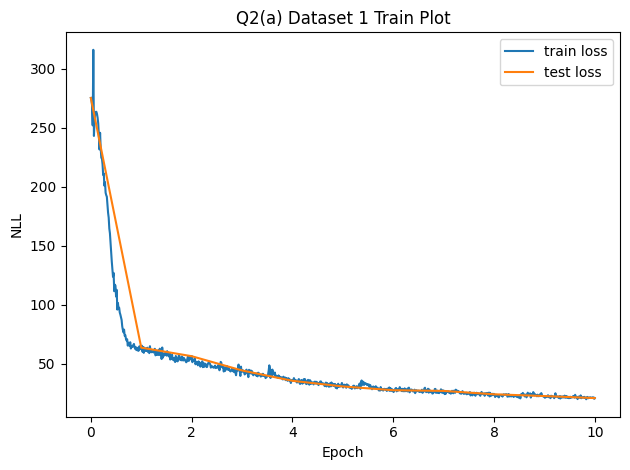

samples shape:  (100, 20, 20, 1)


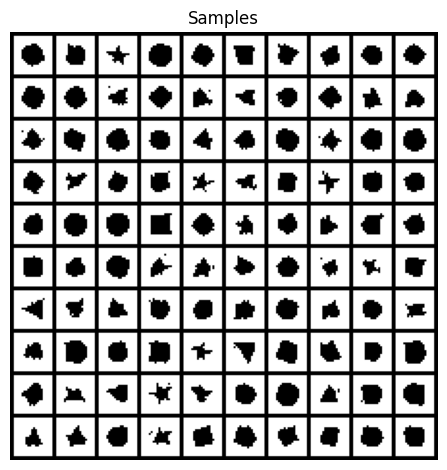

In [8]:
q2a_save_results(1, q2_a)

data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data


Epoch 1/10: 100%|██████████| 469/469 [00:10<00:00, 43.04it/s, Loss=68.7]


Epoch 1: Test Loss: 69.982057


Epoch 2/10: 100%|██████████| 469/469 [00:10<00:00, 42.91it/s, Loss=68.3]


Epoch 2: Test Loss: 66.214365


Epoch 3/10: 100%|██████████| 469/469 [00:11<00:00, 42.53it/s, Loss=64.3]


Epoch 3: Test Loss: 65.107751


Epoch 4/10: 100%|██████████| 469/469 [00:11<00:00, 42.28it/s, Loss=62]  


Epoch 4: Test Loss: 63.785228


Epoch 5/10: 100%|██████████| 469/469 [00:11<00:00, 42.00it/s, Loss=65.2]


Epoch 5: Test Loss: 63.833508


Epoch 6/10: 100%|██████████| 469/469 [00:11<00:00, 42.03it/s, Loss=62.2]


Epoch 6: Test Loss: 62.760284


Epoch 7/10: 100%|██████████| 469/469 [00:11<00:00, 42.03it/s, Loss=64.5]


Epoch 7: Test Loss: 62.533142


Epoch 8/10: 100%|██████████| 469/469 [00:11<00:00, 42.61it/s, Loss=64.3]


Epoch 8: Test Loss: 62.928753


Epoch 9/10: 100%|██████████| 469/469 [00:10<00:00, 42.89it/s, Loss=61.7]


Epoch 9: Test Loss: 61.973298


Epoch 10/10: 100%|██████████| 469/469 [00:11<00:00, 42.39it/s, Loss=61]  


Epoch 10: Test Loss: 61.620466
Final Test Loss: 61.6205


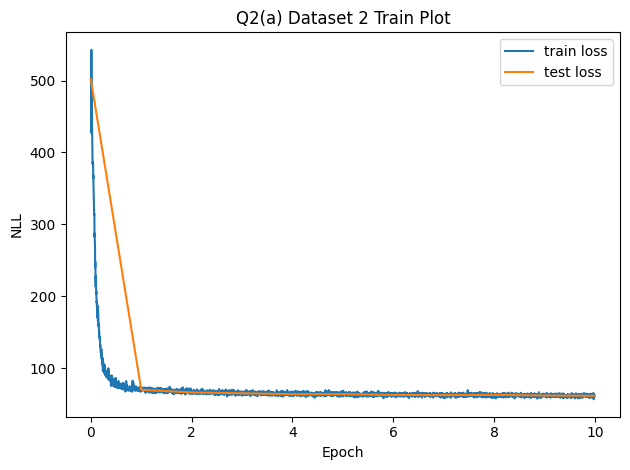

samples shape:  (100, 28, 28, 1)


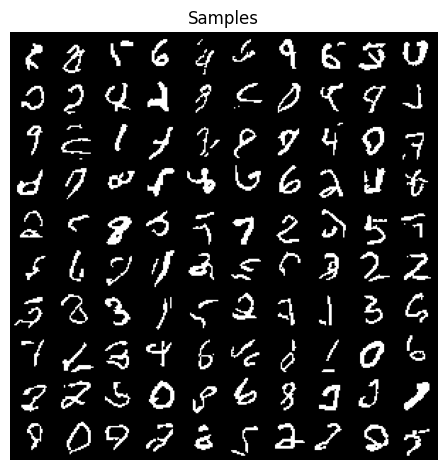

In [9]:
q2a_save_results(2, q2_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next part, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
samples shape:  (100, 20, 20, 3)


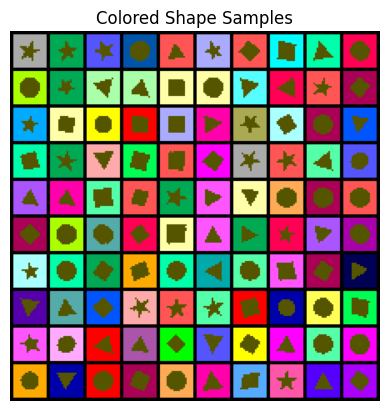

data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
samples shape:  (100, 28, 28, 3)


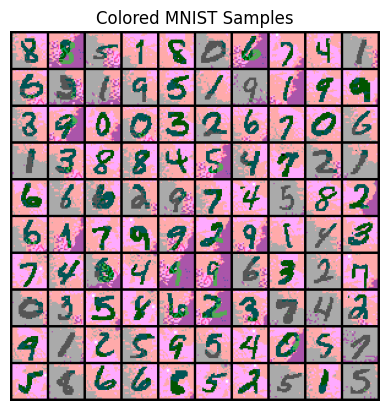

In [10]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set the number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [11]:
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

quiet = False

def train(model, train_loader, optimizer, epoch, grad_clip=None):
  model.train()
  
  train_losses = []
  for x in train_loader:
    x = x.cuda().contiguous()
    loss = model.loss(x)
    optimizer.zero_grad()
    loss.backward()
    if grad_clip:
      torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    train_losses.append(loss.item())
  return train_losses

def eval_loss(model, data_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for x in data_loader:
      x = x.cuda().contiguous()
      loss = model.loss(x)
      total_loss += loss * x.shape[0]
    avg_loss = total_loss / len(data_loader.dataset)

  return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
  epochs, lr = train_args['epochs'], train_args['lr']
  grad_clip = train_args.get('grad_clip', None)
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses = []
  test_losses = [eval_loss(model, test_loader)]
  for epoch in range(epochs):
    model.train()
    train_losses.extend(train(model, train_loader, optimizer, epoch, grad_clip))
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)
    if not quiet:
      print(f'Epoch {epoch}, Test loss {test_loss:.4f}')

  return train_losses, test_losses

class Histogram(nn.Module):
  def __init__(self, d):
    super().__init__()
    self.d = d
    self.logits = nn.Parameter(torch.zeros(d), requires_grad=True)

  def loss(self, x):
    logits = self.logits.unsqueeze(0).repeat(x.shape[0], 1) # batch_size x d
    return F.cross_entropy(logits, x.long())

  def get_distribution(self):
    distribution = F.softmax(self.logits, dim=0)
    return distribution.detach().cpu().numpy()

In [12]:
class MaskedConv2d(nn.Conv2d):
    """
    Implementation of Masked Convolution for PixelCNN
    """
    def __init__(self, mask_type, *args, **kwargs):
        assert mask_type == 'A' or mask_type == 'B'
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input):
        # Apply convolution with mask
        out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                      self.padding, self.dilation, self.groups)
        return out

    def create_mask(self, mask_type):
        # Get kernel size (assuming square kernel)
        k = self.kernel_size[0]
        
        # Set mask to 1 for all positions above the center
        self.mask[:, :, :k // 2] = 1
        
        # Set mask to 1 for positions to the left of center in the center row
        self.mask[:, :, k // 2, :k // 2] = 1
        
        # For type B masks, also set the center pixel to 1
        if mask_type == 'B':
            self.mask[:, :, k // 2, k // 2] = 1
    
class LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        
        # Apply normalization (normalized_shape now matches)
        x = super().forward(x)
        
        # Permute back to [batch, channels, height, width]
        return x.permute(0, 3, 1, 2).contiguous()
  
class ResidualBlock(nn.Module):
    def __init__(self, n_filters, image_shape=None):
        super(ResidualBlock, self).__init__()
        # layer nornalization 
        H, W, _ = image_shape if image_shape is not None else (20, 20, 3) 
        self.layer_norm1 = LayerNorm(n_filters , H, W)
        self.layer_norm2 = LayerNorm(n_filters , H, W)
        self.layer_norm3 = LayerNorm(n_filters , H, W)

        # Main path
        self.conv1 = nn.Conv2d(n_filters, n_filters, kernel_size=1)
        self.conv2 = MaskedConv2d('B', n_filters, n_filters, kernel_size=7, padding=3)
        self.conv3 = nn.Conv2d(n_filters, n_filters, kernel_size=1)

        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Store input for the skip connection
        
        identity = x
        
        # Main path
        out = self.layer_norm1(x)
        out = self.relu(out)
        out = self.conv1(out)
        
        out = self.layer_norm2(out)
        out = self.relu(out)
        out = self.conv2(out)
        
        out = self.layer_norm3(out)
        out = self.relu(out)   
        out = self.conv3(out)

        # Skip connection
        out += identity        
        return out

In [13]:
def compute_loss(logits, targets):
    """
    Compute cross-entropy loss for the PixelCNN model.
    
    Args:
        logits: Tensor of shape [batch_size, C, 4, H, W] - model predictions
        targets: Tensor of shape [batch_size, C, H, W] - ground truth values
        
    Returns:
        Average cross-entropy loss
    """
    logits_reshaped = logits.permute(0, 1, 3, 4, 2).reshape(-1, 4) # [batch_size, C, H, W 4]
    targets_reshaped = targets.reshape(-1).long()
    return F.cross_entropy(logits_reshaped, targets_reshaped)


def evaluate_model(model, data_loader, device):
    """
    Evaluate the model on a dataset
    """
    model.eval()
    total_loss = 0.0
    total_batches = 0
    
    with torch.no_grad():
        for (data,) in data_loader:
            data = data.to(device)
            total_batches += 1
            
            logits = model(data)
            loss = compute_loss(logits, data)
            total_loss += loss.item()
    
    return total_loss / total_batches



def generate_samples(model, num_samples, image_shape, device):
    """
    Generate samples from the model using ancestral sampling.
    Assumes the model expects float inputs representing integer values {0, 1, 2, 3}.
    """
    model.eval()
    H, W, C = image_shape
    
    # Initialize samples tensor with float type, as the model likely expects float inputs
    # even though the values represent discrete levels.
    samples = torch.zeros(num_samples, C, H, W, dtype=torch.float, device=device)
    temperature = 0.6
    with torch.no_grad():
        for h in range(H):
            for w in range(W):
                for c in range(C):
                    logits = model(samples) 
                    
                    pixel_logits = logits[:, c, :, h, w] # Shape: [num_samples, 4]
                    
                    probs = F.softmax(pixel_logits / temperature, dim=1)
                    
                    pixel_samples = torch.multinomial(probs, 1).squeeze(-1) # Shape: [num_samples]
                    
                    samples[:, c, h, w] = pixel_samples.float() 
    
    samples_np = samples.cpu().numpy().transpose(0, 2, 3, 1) 
    
    samples_np = samples_np.astype(np.uint8) 
    
    return samples_np

In [14]:
class PixelCNN(nn.Module):
    """
    PixelCNN model with masked convolutions
    """
    def __init__(self, image_shape, dset_id):
        super(PixelCNN, self).__init__()
        self.image_shape = image_shape
        self.dset_id = dset_id
        self.n_colors = 4
        # Number of input channels (1 for MNIST and shapes)
        in_channels = 3
        
        # Number of filters as specified in the assignment
        n_filters = 120
        
        # First layer: 7x7 masked type A convolution
        self.conv_A = MaskedConv2d('A', in_channels, n_filters, 7, padding=3, bias=True)

        # 8 layers of 7x7 masked type B convolutions
        self.residual_layers = nn.ModuleList([
            ResidualBlock(n_filters, image_shape)
            for _ in range(8)
        ])
        
        # 2 layers of 1x1 masked type B convolutions
        self.conv_B_1x1_layers = nn.ModuleList([
            MaskedConv2d('B', n_filters, n_filters, 1, padding=0, bias=True)
            for _ in range(2)
        ])
        
        # Output 4 logits for each of the 3 color channels
        self.output_conv = nn.Conv2d(n_filters, 4*3, 1, padding=0, bias=True)
        
        # ReLU activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply first mask A convolution
        x = (x.float() / (self.n_colors - 1) - 0.5) / 0.5
        x = self.relu(self.conv_A(x))
        
        # Apply mask B convolutions with ReLU activations
        for layer in self.residual_layers:
            x  = layer(x)
        
        # Apply 1x1 mask B convolutions with ReLU activations
        for layer in self.conv_B_1x1_layers:
            x = self.relu(layer(x))

        
        # Apply final convolution to get logits
        x = self.output_conv(x)


        batch_size, _, height, width = x.shape
        x = x.view(batch_size, 3,4,  height, width) 
        
        return x
    


In [17]:
def q2_b(train_data, test_data, image_shape, dset_id):
    """
    Trains a PixelCNN model for RGB images with 4 possible values per channel.
    
    Args:
        train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
        test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
        image_shape: (H, W, C), height, width, and # of channels of the image
        dset_id: An identifying number of which dataset is given (1 or 2)
                 Used to set different hyperparameters for different datasets

    Returns:
        - train_losses: A (# of training iterations,) numpy array of per-batch training losses
        - test_losses: A (# of epochs + 1,) numpy array of test losses after each epoch (including initialization)
        - samples: A (100, H, W, C) numpy array of generated samples with values in {0, 1, 2, 3}
    """ 
    # Hyperparameters
    batch_size = 128 
    learning_rate = 0.001 * np.sqrt(batch_size / 128)
    num_epochs = 20
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Data preparation
    train_data_tensor = torch.FloatTensor(train_data).permute(0, 3, 1, 2)
    test_data_tensor = torch.FloatTensor(test_data).permute(0, 3, 1, 2)
    
    train_dataset = torch.utils.data.TensorDataset(train_data_tensor)
    test_dataset = torch.utils.data.TensorDataset(test_data_tensor)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=2, 
        pin_memory=(device.type == 'cuda')
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2, 
        pin_memory=(device.type == 'cuda')
    )
    
    # Model initialization
    model = PixelCNN(image_shape, dset_id).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',        # Reduce LR when the monitored metric stops decreasing
        factor=0.5,        # Multiply learning rate by this factor when reducing
        patience=2,        # Number of epochs with no improvement after which LR will be reduced
        # verbose=True,      # Print message when LR is reduced
        min_lr=1e-6        # Lower bound on the learning rate
    )
    
    # Initialize gradient scaler for mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    # Early stopping parameters
    best_loss = float('inf')
    best_model_state = None
    patience = 5
    patience_counter = 0

    # Loss tracking
    train_losses = []
    test_losses = []
    
    # Initial evaluation
    init_test_loss = evaluate_model(model, test_loader, device)
    test_losses.append(init_test_loss)
    print(f"Initial test loss: {init_test_loss:.6f}")
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_train_losses = []
        
        for batch_idx, (data,) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            
            # Use autocast for mixed precision training
            with torch.cuda.amp.autocast():
                logits = model(data)
                loss = compute_loss(logits, data)

            # Scale the loss and backpropagate
            scaler.scale(loss).backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # Reduced from 1.0 for stability
            
            # Update weights with scaled gradients
            scaler.step(optimizer)
            scaler.update()
            
            loss_value = loss.item()
            train_losses.append(loss_value)
            epoch_train_losses.append(loss_value)
            
            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss_value:.6f}')
        
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        print(f'Epoch {epoch+1} average training loss: {avg_train_loss:.6f}')
        
        # Evaluate the model
        test_loss = evaluate_model(model, test_loader, device)
        test_losses.append(test_loss)
        print(f'Epoch {epoch+1} test loss: {test_loss:.6f}')
        
        # Update learning rate based on test loss
        scheduler.step(test_loss)
        
        # Print current learning rate (correct way for ReduceLROnPlateau)
        print(f'Current learning rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early stopping check
        if test_loss < best_loss:
            best_loss = test_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print(f"New best model with test loss: {best_loss:.6f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load the best model for sampling
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with test loss: {best_loss:.6f}")
    
    # Generate samples with improved sampling
    samples = generate_samples(model, 100, image_shape, device)
    
    return np.array(train_losses), np.array(test_losses), samples


def evaluate_model(model, data_loader, device):
    """
    Evaluate the model on a dataset
    """
    model.eval()
    total_loss = 0.0
    total_batches = 0
    
    with torch.no_grad():
        for (data,) in data_loader:
            data = data.to(device)
            total_batches += 1
            
            with torch.cuda.amp.autocast():  # Use autocast for evaluation too
                logits = model(data)
                loss = compute_loss(logits, data)
                
            total_loss += loss.item()
    
    return total_loss / total_batches


### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
Using device: cuda


/tmp/ipykernel_2361820/2857294626.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_2361820/2857294626.py:162: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use autocast for evaluation too


Initial test loss: 1.388850


/tmp/ipykernel_2361820/2857294626.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch: 1/20, Batch: 0/82, Loss: 1.391449
Epoch: 1/20, Batch: 10/82, Loss: 1.329665
Epoch: 1/20, Batch: 20/82, Loss: 1.191522
Epoch: 1/20, Batch: 30/82, Loss: 0.999146
Epoch: 1/20, Batch: 40/82, Loss: 0.806963
Epoch: 1/20, Batch: 50/82, Loss: 0.667744
Epoch: 1/20, Batch: 60/82, Loss: 0.571827
Epoch: 1/20, Batch: 70/82, Loss: 0.516736
Epoch: 1/20, Batch: 80/82, Loss: 0.472714
Epoch 1 average training loss: 0.874104
Epoch 1 test loss: 0.472679
Current learning rate: 0.001000
New best model with test loss: 0.472679
Epoch: 2/20, Batch: 0/82, Loss: 0.465338
Epoch: 2/20, Batch: 10/82, Loss: 0.428478
Epoch: 2/20, Batch: 20/82, Loss: 0.404972
Epoch: 2/20, Batch: 30/82, Loss: 0.361007
Epoch: 2/20, Batch: 40/82, Loss: 0.347785
Epoch: 2/20, Batch: 50/82, Loss: 0.336060
Epoch: 2/20, Batch: 60/82, Loss: 0.321864
Epoch: 2/20, Batch: 70/82, Loss: 0.314387
Epoch: 2/20, Batch: 80/82, Loss: 0.283376
Epoch 2 average training loss: 0.361904
Epoch 2 test loss: 0.286814
Current learning rate: 0.001000
New be

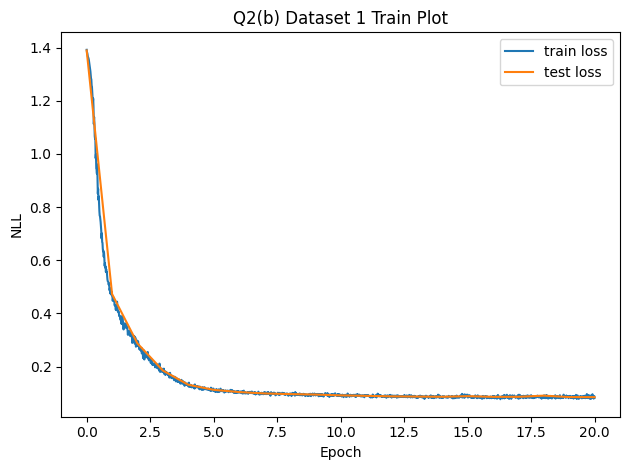

samples shape:  (100, 20, 20, 3)


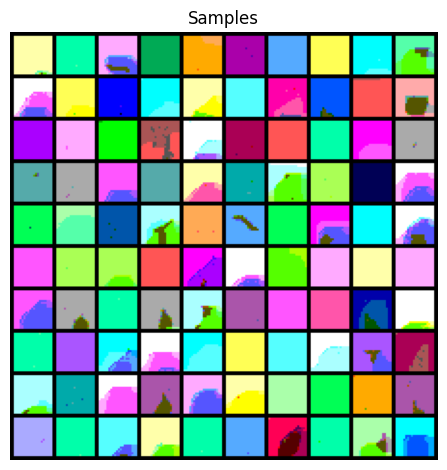

In [18]:
q2b_save_results(1, 'b', q2_b)

data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data


Using device: cuda


/tmp/ipykernel_2361820/2857294626.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_2361820/2857294626.py:162: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Use autocast for evaluation too


Initial test loss: 1.365160


/tmp/ipykernel_2361820/2857294626.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch: 1/20, Batch: 0/469, Loss: 1.364236
Epoch: 1/20, Batch: 10/469, Loss: 1.236289
Epoch: 1/20, Batch: 20/469, Loss: 0.936831
Epoch: 1/20, Batch: 30/469, Loss: 0.858414
Epoch: 1/20, Batch: 40/469, Loss: 0.776309
Epoch: 1/20, Batch: 50/469, Loss: 0.680986
Epoch: 1/20, Batch: 60/469, Loss: 0.598954
Epoch: 1/20, Batch: 70/469, Loss: 0.516625
Epoch: 1/20, Batch: 80/469, Loss: 0.491731
Epoch: 1/20, Batch: 90/469, Loss: 0.435464
Epoch: 1/20, Batch: 100/469, Loss: 0.415777
Epoch: 1/20, Batch: 110/469, Loss: 0.375786
Epoch: 1/20, Batch: 120/469, Loss: 0.360483
Epoch: 1/20, Batch: 130/469, Loss: 0.322623
Epoch: 1/20, Batch: 140/469, Loss: 0.319569
Epoch: 1/20, Batch: 150/469, Loss: 0.290041
Epoch: 1/20, Batch: 160/469, Loss: 0.281337
Epoch: 1/20, Batch: 170/469, Loss: 0.275442
Epoch: 1/20, Batch: 180/469, Loss: 0.276323
Epoch: 1/20, Batch: 190/469, Loss: 0.266604
Epoch: 1/20, Batch: 200/469, Loss: 0.266382
Epoch: 1/20, Batch: 210/469, Loss: 0.264654
Epoch: 1/20, Batch: 220/469, Loss: 0.260019

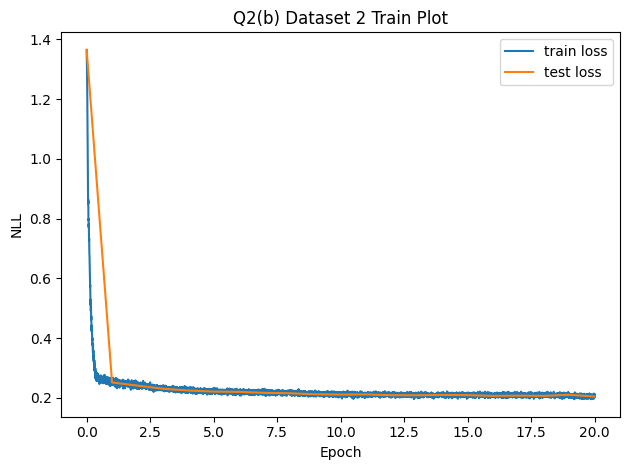

samples shape:  (100, 28, 28, 3)


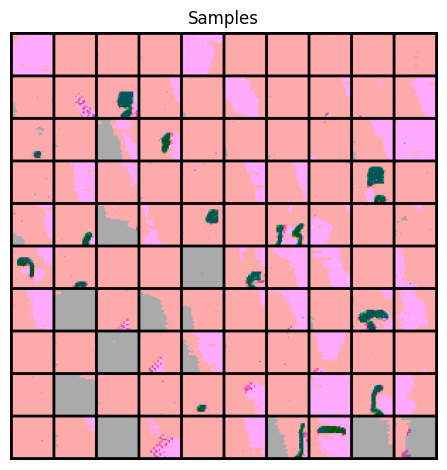

In [19]:
q2b_save_results(2, 'b', q2_b)

# Question 3: Causal Transformer - iGPT

Now we will move onto the current most popular and widespread autoregressive model, the transformer.

## Part (a) Autoregressive Transformer on Shapes and MNIST
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer). 

Some additional notes about your transformer implementation:
 * iGPT uses learned positional encodings. We recommend to use those here as well. However, you may also use sinusoidal positional encodings if you wish (see the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper)
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a cosine learning rate decay.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762) 
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model



In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        """
        q: (batch_size, n_heads, seq_len, head_size)
        k: (batch_size, n_heads, seq_len, head_size)
        v: (batch_size, n_heads, seq_len, head_size)
        """
        d_k = q.shape[-1]
        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(d_k)  # (batch_size, n_heads, seq_len, seq_len)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = torch.softmax(scores, dim=-1)  # (batch_size, n_heads, seq_len, seq_len)
        attention_weights = self.dropout(attention_weights)  # (batch_size, n_heads, seq_len, seq_len)

        output = torch.matmul(attention_weights, v)  # (batch_size, n_heads, seq_len, head_size)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.0, cache=False):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_size = d_model // n_heads
        self.use_cache = cache

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        self.out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.attention = ScaledDotProductAttention(dropout=dropout)
        self.cached_k = None
        self.cached_v = None

    def split_heads(self, x):
        """
        x: (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, d_model = x.shape
        return x.view(batch_size, seq_len, self.n_heads, self.head_size).transpose(1, 2)  # (batch_size, n_heads, seq_len, head_size)
    
    def combine_heads(self, x):
        """
        x: (batch_size, n_heads, seq_len, head_size)
        """
        batch_size, n_heads, seq_len, head_size = x.shape
        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)  # (batch_size, seq_len, d_model)
    
    def forward(self, x, mask=None, use_cache=False, past_key_values=None):
        batch_size, seq_len, d_model = x.shape
        if past_key_values is not None:
            self.cached_k, self.cached_v = past_key_values
        q = self.W_q(x)  # (batch_size, seq_len, d_model)
        k = self.W_k(x)
        v = self.W_v(x)

        q = self.split_heads(q)  # (batch_size, n_heads, seq_len, head_size)
        k = self.split_heads(k)
        v = self.split_heads(v)
        
        # Use KV cache if enabled
        if use_cache and self.cached_k is not None and self.cached_v is not None:
            # Concatenate current k, v with cached k, v
            k = torch.cat([self.cached_k, k], dim=2)
            v = torch.cat([self.cached_v, v], dim=2)


            self.cached_k = k
            self.cached_v = v
        
        # Create causal mask if needed
        if mask is None:
            # If using cache, adjust mask to account for the full sequence length
            full_seq_len = k.size(2)
            # For cached version, we need to adjust the mask to allow attention to all past tokens
            if use_cache and self.cached_k is not None:
                # Create a mask where current tokens can attend to all previous tokens
                # Current sequence position is at seq_len
                seq_position = seq_len
                # Create a mask that allows each token to see itself and all previous tokens
                mask = torch.ones(seq_len, full_seq_len).to(x.device)
                # Make it causal by setting future positions to 0
                mask[:, seq_position:] = 0
            else:
                # Standard causal mask for the full sequence
                mask = torch.tril(torch.ones(full_seq_len, full_seq_len)).to(x.device)
            
            mask = mask.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, seq_len)

        # Use the attention module directly
        output = self.attention(q, k, v, mask)  # (batch_size, n_heads, seq_len, head_size)
        
        # Combine heads
        output = self.combine_heads(output)  # (batch_size, seq_len, d_model)
        past_key_values = (k, v)
        if use_cache:
            return self.dropout(self.out(output)) , past_key_values
        else:
            return self.dropout(self.out(output))
    
    def clear_cache(self):
        self.cached_k = None
        self.cached_v = None
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1, use_cache=False):
        super().__init__()
        self.masked_mha = MultiHeadAttention(d_model, n_heads, dropout, cache=use_cache)
        self.layer_norm1 = nn.LayerNorm(d_model)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),  
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, use_cache=False, past_key_values=None):

        # Self-attention with residual connection and layer normalization
        residual = x
        x = self.layer_norm1(x)  # Pre-norm architecture
        if use_cache and past_key_values is not None:
            x, past_key_values = self.masked_mha(x, use_cache=use_cache, past_key_values=past_key_values)
        else:
            x = self.masked_mha(x)
            
        x = residual + x  # Residual connection
        
        # Feed forward with residual connection and layer normalization
        residual = x
        x = self.layer_norm2(x)  # Pre-norm architecture
        x = self.feed_forward(x)
        x = residual + x  # Residual connection
        if use_cache:
            return x , past_key_values
        else:
            return x
    
    def clear_cache(self):
        self.masked_mha.clear_cache()

class iGPT(nn.Module):
    def __init__(self, vocab_size, context_length, d_model, n_heads, n_layers, dropout=0.1, use_cache=False):
        super().__init__()
        self.vocab_size = vocab_size
        self.context_length = context_length
        self.d_model = d_model
        self.n_heads = n_heads  
        self.n_layers = n_layers
        self.dropout = dropout
        self.use_cache = use_cache
        
        # Token embedding
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional embedding (learned, as per iGPT specs)
        self.position_embedding = nn.Embedding(context_length, d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Stack of decoder layers
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, dropout, use_cache=use_cache) 
            for _ in range(n_layers)
        ])
        
        # Final layer norm
        self.layer_norm = nn.LayerNorm(d_model)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)

    def forward(self, x, past_key_values=None, use_cache=False):
        # x shape: (batch_size, seq_len)
        batch_size, seq_len = x.shape
        device = x.device
        
        # Create position indices
        positions = torch.arange(0, seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)
        
        # Get embeddings
        token_emb = self.token_embedding(x)  # (batch_size, seq_len, d_model)
        pos_emb = self.position_embedding(positions)  # (batch_size, seq_len, d_model)
        
        # Combine embeddings
        x = token_emb + pos_emb  # (batch_size, seq_len, d_model)
        x = self.dropout(x)
        
        # Apply decoder layers
        past_key_values = None
        for layer in self.decoder_layers:
            if use_cache:
                x, past_key_values = layer(x, use_cache=use_cache, past_key_values=past_key_values)
            else:
                x = layer(x)
        
        # Apply final layer norm
        x = self.layer_norm(x)  # (batch_size, seq_len, d_model)
        
        # Project to vocabulary
        logits = self.output_projection(x)  # (batch_size, seq_len, vocab_size)
        if use_cache:
            return logits, past_key_values
        else:
            return logits
    
    def clear_cache(self):
        for layer in self.decoder_layers:
            layer.clear_cache()

In [11]:
def test_igpt():
    # Define dummy parameters
    vocab_size = 10
    context_length = 20
    d_model = 128
    n_heads = 4
    n_layers = 2
    batch_size = 5
    seq_len = context_length

    # Create a dummy input tensor
    dummy_input = torch.randint(0, vocab_size, (batch_size, seq_len))

    # Initialize the iGPT model
    model = iGPT(vocab_size, context_length, d_model, n_heads, n_layers)

    # Test token embedding
    token_emb = model.token_embedding(dummy_input)
    print("Token embedding shape:", token_emb.shape)
    assert token_emb.shape == (batch_size, seq_len, d_model), "Token embedding shape mismatch!"
    
    # Test position embedding
    positions = torch.arange(0, seq_len, dtype=torch.long, device=dummy_input.device).unsqueeze(0).expand(batch_size, -1)
    pos_emb = model.position_embedding(positions)
    print("Position embedding shape:", pos_emb.shape)
    assert pos_emb.shape == (batch_size, seq_len, d_model), "Position embedding shape mismatch!"
    
    # Test each decoder layer
    x = token_emb + pos_emb
    x = model.dropout(x)
    for i, layer in enumerate(model.decoder_layers):
        x_before = x.clone()
        x = layer(x)
        print(f"Decoder layer {i} output shape:", x.shape)
        assert x.shape == (batch_size, seq_len, d_model), f"Decoder layer {i} output shape mismatch!"
        # Check that the layer actually modified the input
        assert not torch.allclose(x, x_before), f"Decoder layer {i} did not modify the input!"
    
    # Test final layer norm
    x_before = x.clone()
    x = model.layer_norm(x)
    print("Layer norm output shape:", x.shape)
    assert x.shape == (batch_size, seq_len, d_model), "Layer norm output shape mismatch!"
    
    # Test output projection
    logits = model.output_projection(x)
    print("Output logits shape:", logits.shape)
    assert logits.shape == (batch_size, seq_len, vocab_size), "Output logits shape mismatch!"

    # Full forward pass
    output = model(dummy_input)
    print("Final output shape:", output.shape)
    assert output.shape == (batch_size, seq_len, vocab_size), "Final output shape mismatch!"

    print("iGPT model test passed! All layers are implemented correctly.")

# Run the test
test_igpt()

Token embedding shape: torch.Size([5, 20, 128])
Position embedding shape: torch.Size([5, 20, 128])
Decoder layer 0 output shape: torch.Size([5, 20, 128])
Decoder layer 1 output shape: torch.Size([5, 20, 128])
Layer norm output shape: torch.Size([5, 20, 128])
Output logits shape: torch.Size([5, 20, 10])
Final output shape: torch.Size([5, 20, 10])
iGPT model test passed! All layers are implemented correctly.


In [12]:
def generate_samples(model, sequence_length, vocab_size, image_shape, device, num_samples=100, use_cache=False, test_mode=False):
    """
    Generates samples from the trained model.
    
    Args:
        model: The trained iGPT model
        sequence_length: Length of token sequences including <bos>
        vocab_size: Size of vocabulary
        image_shape: (H, W, C) tuple specifying image dimensions
        device: Device to run generation on
        num_samples: Number of samples to generate
        use_cache: Whether to use caching for faster sampling
        test_mode: If True, only generate first 5 samples and fill the rest with blank images
        
    Returns:
        Numpy array of generated samples with shape (num_samples, H, W, C)
        and a list of generation times
    """
    H, W, C = image_shape
    model.eval()
    samples = []
    import time
    time_list = []
    
    # Determine how many samples to actually generate
    samples_to_generate = 5 if test_mode else num_samples
    
    with torch.no_grad():
        for i in range(num_samples):
            if test_mode and i >= samples_to_generate:
                # In test mode, fill remaining samples with blank images
                if C == 3:
                    blank_sample = np.zeros((H, W, C), dtype=np.uint8)
                else:
                    blank_sample = np.zeros((H, W, C), dtype=np.uint8)
                samples.append(blank_sample)
                time_list.append(0.0)  # No time spent on blank images
                continue
                
            start_time = time.time()
            
            # Start with just the <bos> token
            sample = torch.zeros(1, sequence_length, dtype=torch.long, device=device)
            sample[:, 0] = 0  # <bos> token
            
            # Cache for key-value pairs if using caching
            past_key_values = None
            
            # Autoregressive generation - one token at a time
            for i in range(1, sequence_length):
                if use_cache and past_key_values is not None:
                    # Only need to process the new token with cached key-values
                    logits, past_key_values = model(sample[:, i-1:i], past_key_values=past_key_values, use_cache=True)
                    # print(f"logits shape: {logits.shape}")
                    logits = logits[:, -1, :]  # Get prediction for current position
                else:
                    # Process the entire sequence up to current position
                    if use_cache:
                        logits, past_key_values = model(sample[:, :i], use_cache=True)
                        logits = logits[:, -1, :]  # Get prediction for current position
                    else:
                        logits = model(sample)
                        logits = logits[:, i-1, :] # Get prediction for current position
                # print(f"past_key_values: {past_key_values}")
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, 1).squeeze(-1)
                sample[:, i] = next_token
            
            # Convert tokens back to image format (remove <bos> token)
            sample_tokens = sample[:, 1:].cpu().numpy().reshape(H, W)
            
            # Convert single tokens back to RGB values if needed
            if C == 3:
                sample_rgb = np.zeros((H, W, C), dtype=np.uint8)
                sample_rgb[:, :, 0] = sample_tokens // 16  # R = token // 16
                sample_rgb[:, :, 1] = (sample_tokens % 16) // 4  # G = (token % 16) // 4
                sample_rgb[:, :, 2] = sample_tokens % 4  # B = token % 4
                samples.append(sample_rgb)
            else:
                samples.append(sample_tokens.reshape(H, W, C))
            
            end_time = time.time()
            time_list.append(end_time - start_time)
    
    return np.array(samples), np.array(time_list)


In [13]:
import math

def create_dataset(data, image_shape, batch_size):
    """
    Converts image data to token sequences and creates PyTorch DataLoader.
    
    Args:
        data: A (n_samples, H, W, C) uint8 numpy array of images
        image_shape: (H, W, C) tuple specifying image dimensions
        batch_size: Batch size for DataLoader
        
    Returns:
        DataLoader object with tokenized image sequences
    """
    H, W, C = image_shape
    
    # Convert RGB pixels to single tokens (4 values per channel = 64 possible values)
    # Shape: (n_samples, H, W, C) -> (n_samples, H, W)
    if C == 3:
        # Convert RGB values to a single token: r*16 + g*4 + b
        # Each channel has values in {0,1,2,3}, so we can encode as a single number 0-63
        data_tokens = (data[:,:,:,0] * 16 + data[:,:,:,1] * 4 + data[:,:,:,2])
    else:
        # For grayscale, just use the values directly
        data_tokens = data.reshape(-1, H, W)
    
    # Flatten spatial dimensions to create sequences
    # Shape: (n_samples, H, W) -> (n_samples, H*W)
    data_flat = data_tokens.reshape(-1, H * W)
    
    # Convert to PyTorch tensors
    dataset = torch.utils.data.TensorDataset(torch.tensor(data_flat, dtype=torch.long))
    
    # Create data loader
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

def evaluate_model(model, data_loader, sequence_length, vocab_size, device):
    """
    Evaluates model performance on a dataset.
    
    Args:
        model: The iGPT model
        data_loader: DataLoader containing tokenized images
        sequence_length: Length of token sequences including <bos>
        vocab_size: Size of vocabulary
        device: Device to run evaluation on
        
    Returns:
        Average loss (negative log-likelihood) per dimension
    """
    model.eval()
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for (data,) in data_loader:
            data = data.to(device)  # Shape: (batch_size, sequence_length-1)
            batch_size = data.size(0)
            
            # Create input with <bos> token (0) at the beginning
            # Shape: (batch_size, sequence_length)
            input_seq = torch.zeros(batch_size, sequence_length, dtype=torch.long, device=device)
            input_seq[:, 0] = 0  # <bos> token
            input_seq[:, 1:] = data  # actual image data
            
            # Create targets (the image tokens to predict)
            # Shape: (batch_size, sequence_length-1)
            targets = data
            
            # Forward pass
            # Shape: (batch_size, sequence_length, vocab_size) -> (batch_size, sequence_length-1, vocab_size)
            logits = model(input_seq)[:, :-1, :]  # Remove last position's prediction
            
            # Compute loss
            loss = F.cross_entropy(logits.reshape(-1, vocab_size), targets.reshape(-1), reduction='sum')
            
            total_loss += loss.item()
            total_samples += batch_size * (sequence_length - 1)
    
    return total_loss / total_samples



def train_igpt(model, train_loader, test_loader, sequence_length, vocab_size, 
               device, num_epochs, learning_rate):
    """
    Trains the iGPT model.
    
    Args:
        model: The iGPT model to train
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        sequence_length: Length of token sequences including <bos>
        vocab_size: Size of vocabulary
        device: Device to train on
        num_epochs: Number of training epochs
        learning_rate: Initial learning rate
        
    Returns:
        train_losses: Array of training losses per minibatch
        test_losses: Array of test losses per epoch
    """
    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler with warmup and cosine decay
    warmup_steps = 1000
    total_steps = len(train_loader) * num_epochs
    
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            decay_ratio = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    # Initialize arrays to store losses
    train_losses = []
    test_losses = [evaluate_model(model, test_loader, sequence_length, vocab_size, device)]
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        
        for batch_idx, (data,) in enumerate(train_loader):
            data = data.to(device)  # Shape: (batch_size, sequence_length-1)
            batch_size = data.size(0)
            
            # Create input with <bos> token (0) at the beginning
            # Shape: (batch_size, sequence_length)
            input_seq = torch.zeros(batch_size, sequence_length, dtype=torch.long, device=device)
            input_seq[:, 0] = 0  # <bos> token
            input_seq[:, 1:] = data  # actual image data 
            
            # Create targets (the image tokens to predict)
            # Shape: (batch_size, sequence_length-1)
            targets = data
            
            # Forward pass
            # Shape: (batch_size, sequence_length, vocab_size) -> (batch_size, sequence_length-1, vocab_size)
            logits = model(input_seq)[:, :-1, :]  # Remove last position's prediction (don't predict <eos>)
            
            # Compute loss
            loss = F.cross_entropy(logits.reshape(-1, vocab_size), targets.reshape(-1))
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # Record loss
            train_losses.append(loss.item())
            epoch_losses.append(loss.item())
            
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        # Evaluate on test set after each epoch
        test_loss = evaluate_model(model, test_loader, sequence_length, vocab_size, device)
        test_losses.append(test_loss)
        print(f"Epoch {epoch+1}/{num_epochs} completed. Test Loss: {test_loss:.4f}")
    
    return np.array(train_losses), np.array(test_losses)

def q3_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of color images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of color images with values in {0, 1}
    image_shape: (H, W, 1), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    # Hyperparameters
    batch_size = 64
    learning_rate = 1e-3
    num_epochs = 15
    
    # Model parameters as recommended in the instructions
    d_model = 128
    n_heads = 4
    n_layers = 2
    
    # Determine sequence length and vocabulary size
    H, W, C = image_shape
    sequence_length = H * W * C + 1  # +1 for <bos> token
    vocab_size = 2  # Binary images with values in {0, 1}
    
    # Create datasets and data loaders
    train_loader = create_dataset(train_data, image_shape, batch_size)
    test_loader = create_dataset(test_data, image_shape, batch_size)
    
    # Initialize model and move to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = iGPT(vocab_size, sequence_length, d_model, n_heads, n_layers).to(device)
    
    # Train the model
    train_losses, test_losses = train_igpt(model, train_loader, test_loader, 
                                          sequence_length, vocab_size, device,
                                          num_epochs, learning_rate)
    
    # Generate samples
    # save the model
    torch.save(model, 'model_no_cache.pth')
    samples , _= generate_samples(model, sequence_length, vocab_size, image_shape, device)
    
    return train_losses, test_losses, samples

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results

data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
Epoch 1/15, Batch 0/164, Loss: 0.7565
Epoch 1/15, Batch 50/164, Loss: 0.3444
Epoch 1/15, Batch 100/164, Loss: 0.2132
Epoch 1/15, Batch 150/164, Loss: 0.2036
Epoch 1/15 completed. Test Loss: 0.1965
Epoch 2/15, Batch 0/164, Loss: 0.1971
Epoch 2/15, Batch 50/164, Loss: 0.1753
Epoch 2/15, Batch 100/164, Loss: 0.1454
Epoch 2/15, Batch 150/164, Loss: 0.1234
Epoch 2/15 completed. Test Loss: 0.1108
Epoch 3/15, Batch 0/164, Loss: 0.1324
Epoch 3/15, Batch 50/164, Loss: 0.1107
Epoch 3/15, Batch 100/164, Loss: 0.0993
Epoch 3/15, Batch 150/164, Loss: 0.1016
Epoch 3/15 completed. Test Loss: 0.0928
Epoch 4/15, Batch 0/164, Loss: 0.0973
Epoch 4/15, Batch 50/164, Loss: 0.0934
Epoch 4/15, Batch 100/164, Loss: 0.0873
Epoch 4/15, Batch 150/164, Loss: 0.0844
Epoch 4/15 completed. Test Loss: 0.0796
Epoch 5/15, Batch 0/164, Loss: 0.0899
Epoch 5/15, Batch 50/164, Loss: 0.0852
Epoch 5/15, Batch 100/164, Loss: 0.0808
Epoch 5/15, Batch 150/164, Loss: 0

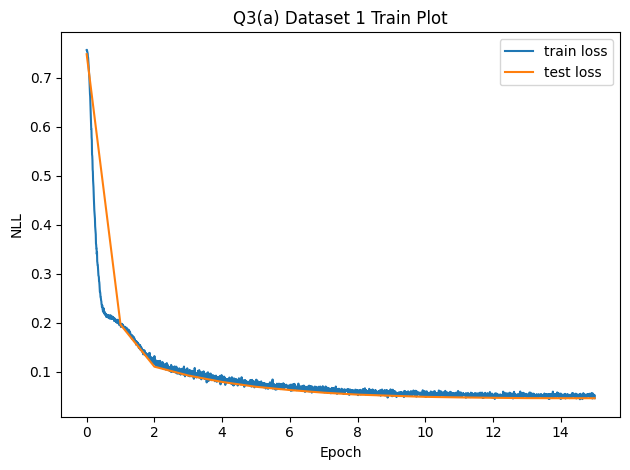

samples shape:  (100, 20, 20, 1)


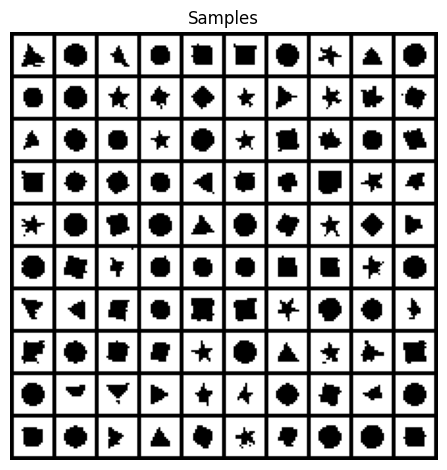

In [11]:
q3ab_save_results(1, 'a', q3_a)

data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
Epoch 1/15, Batch 0/938, Loss: 0.6212
Epoch 1/15, Batch 50/938, Loss: 0.2837
Epoch 1/15, Batch 100/938, Loss: 0.2267
Epoch 1/15, Batch 150/938, Loss: 0.2190
Epoch 1/15, Batch 200/938, Loss: 0.2150
Epoch 1/15, Batch 250/938, Loss: 0.2095
Epoch 1/15, Batch 300/938, Loss: 0.1933
Epoch 1/15, Batch 350/938, Loss: 0.1886
Epoch 1/15, Batch 400/938, Loss: 0.1882
Epoch 1/15, Batch 450/938, Loss: 0.1887
Epoch 1/15, Batch 500/938, Loss: 0.1821
Epoch 1/15, Batch 550/938, Loss: 0.1730
Epoch 1/15, Batch 600/938, Loss: 0.1748
Epoch 1/15, Batch 650/938, Loss: 0.1798
Epoch 1/15, Batch 700/938, Loss: 0.1679
Epoch 1/15, Batch 750/938, Loss: 0.1672
Epoch 1/15, Batch 800/938, Loss: 0.1667
Epoch 1/15, Batch 850/938, Loss: 0.1572
Epoch 1/15, Batch 900/938, Loss: 0.1585
Epoch 1/15 completed. Test Loss: 0.1423
Epoch 2/15, Batch 0/938, Loss: 0.1555
Epoch 2/15, Batch 50/938, Loss: 0.1412
Epoch 2/15, Batch 100/938, Loss: 0.1427
Epoch 2/15, Batch 150/938

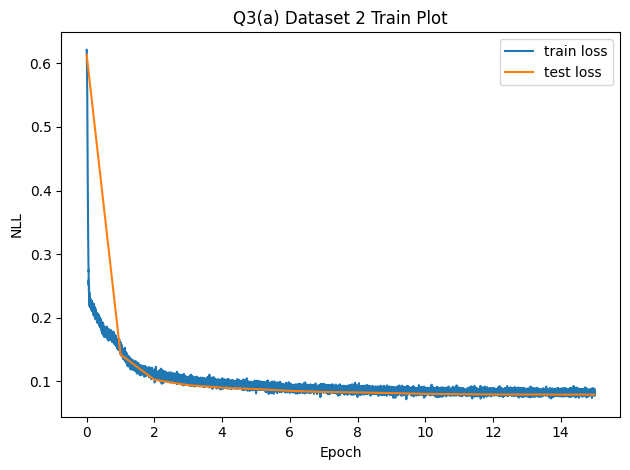

samples shape:  (100, 28, 28, 1)


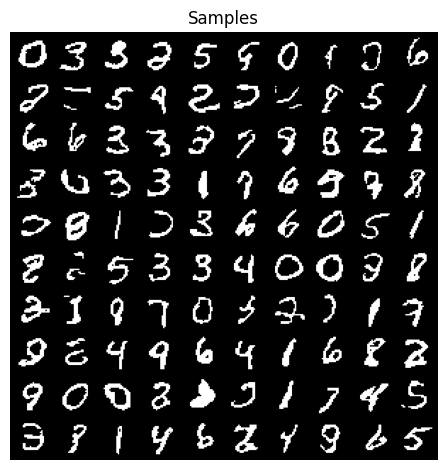

In [12]:
q3ab_save_results(2, 'a', q3_a)

## Part (b) iGPT on Colored Shapes and MNIST

Now, implement an iGPT that models color. In order to reduce the length of token sequences, iGPT models each RGB pixel as a **single** token. This effectively reduces the context length from H*W*C to just H*W. iGPT does this through a k-means clustering approach. Because our images only each can only take on 4 values (2 bits) per channel, we can represent each pixel with 64 values (6 bits). Convert the dataset into an image of tokens and train iGPT on the colored shapes and MNIST dataset.

Checkout the iGPT paper for more details: [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 

Training times and hyperparameter settings should be the same as part (a), except train for longer (15 epochs)

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [13]:
def q3_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    batch_size = 64
    learning_rate = 1e-3
    num_epochs = 15
    
    # Model parameters as recommended in the instructions
    d_model = 128
    n_heads = 4
    n_layers = 2
        
    H, W, C = image_shape
    sequence_length = H * W + 1  # +1 for <bos> token
    vocab_size = 64  # each pixel be represented by 6 bits
    
    # Create datasets and data loaders
    train_loader = create_dataset(train_data, image_shape, batch_size)
    test_loader = create_dataset(test_data, image_shape, batch_size)
    # Initialize model and move to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = iGPT(vocab_size, sequence_length, d_model, n_heads, n_layers).to(device)
    
    # Train the model
    train_losses, test_losses = train_igpt(model, train_loader, test_loader, 
                                          sequence_length, vocab_size, device,
                                          num_epochs, learning_rate)
    
    # save the model
    torch.save(model, f'model_colored_no_cache_{dset_id}.pth')
    # Generate samples
    samples ,_ = generate_samples(model, sequence_length, vocab_size, image_shape, device)
    
    return train_losses, test_losses, samples

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results

data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
Epoch 1/15, Batch 0/164, Loss: 4.2606
Epoch 1/15, Batch 50/164, Loss: 3.9352
Epoch 1/15, Batch 100/164, Loss: 2.9784
Epoch 1/15, Batch 150/164, Loss: 1.8770
Epoch 1/15 completed. Test Loss: 1.3999
Epoch 2/15, Batch 0/164, Loss: 1.5793
Epoch 2/15, Batch 50/164, Loss: 0.7684
Epoch 2/15, Batch 100/164, Loss: 0.4597
Epoch 2/15, Batch 150/164, Loss: 0.3514
Epoch 2/15 completed. Test Loss: 0.2962
Epoch 3/15, Batch 0/164, Loss: 0.3175
Epoch 3/15, Batch 50/164, Loss: 0.2741
Epoch 3/15, Batch 100/164, Loss: 0.2230
Epoch 3/15, Batch 150/164, Loss: 0.1922
Epoch 3/15 completed. Test Loss: 0.1610
Epoch 4/15, Batch 0/164, Loss: 0.1853
Epoch 4/15, Batch 50/164, Loss: 0.1634
Epoch 4/15, Batch 100/164, Loss: 0.1535
Epoch 4/15, Batch 150/164, Loss: 0.1427
Epoch 4/15 completed. Test Loss: 0.1260
Epoch 5/15, Batch 0/164, Loss: 0.1391
Epoch 5/15, Batch 50/164, Loss: 0.1338
Epoch 5/15, Batch 100/164, Loss: 0.1241
Epoch 5/15, Batch 150/164, Loss: 0

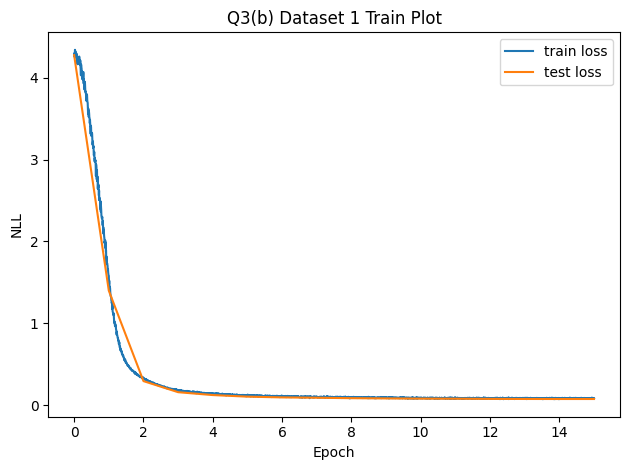

samples shape:  (100, 20, 20, 3)


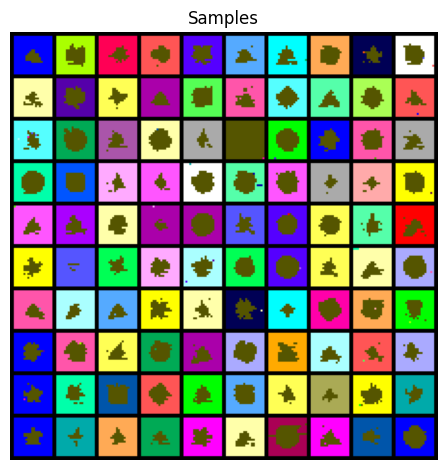

In [14]:
q3ab_save_results(1, 'b', q3_b)

data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
Epoch 1/15, Batch 0/938, Loss: 4.1959
Epoch 1/15, Batch 50/938, Loss: 3.3272
Epoch 1/15, Batch 100/938, Loss: 1.6369
Epoch 1/15, Batch 150/938, Loss: 1.1212
Epoch 1/15, Batch 200/938, Loss: 0.9332
Epoch 1/15, Batch 250/938, Loss: 0.8661
Epoch 1/15, Batch 300/938, Loss: 0.8122
Epoch 1/15, Batch 350/938, Loss: 0.8091
Epoch 1/15, Batch 400/938, Loss: 0.7632
Epoch 1/15, Batch 450/938, Loss: 0.7805
Epoch 1/15, Batch 500/938, Loss: 0.7259
Epoch 1/15, Batch 550/938, Loss: 0.6978
Epoch 1/15, Batch 600/938, Loss: 0.6527
Epoch 1/15, Batch 650/938, Loss: 0.6754
Epoch 1/15, Batch 700/938, Loss: 0.6195
Epoch 1/15, Batch 750/938, Loss: 0.6289
Epoch 1/15, Batch 800/938, Loss: 0.6234
Epoch 1/15, Batch 850/938, Loss: 0.6313
Epoch 1/15, Batch 900/938, Loss: 0.6226
Epoch 1/15 completed. Test Loss: 0.5847
Epoch 2/15, Batch 0/938, Loss: 0.5990
Epoch 2/15, Batch 50/938, Loss: 0.6081
Epoch 2/15, Batch 100/938, Loss: 0.6120
Epoch 2/15, Batch 150/938

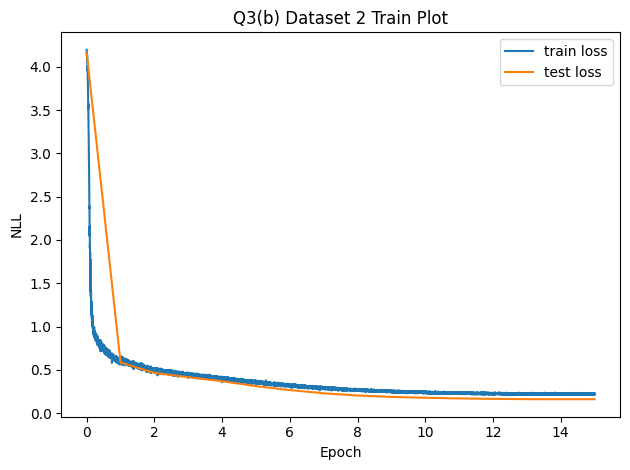

samples shape:  (100, 28, 28, 3)


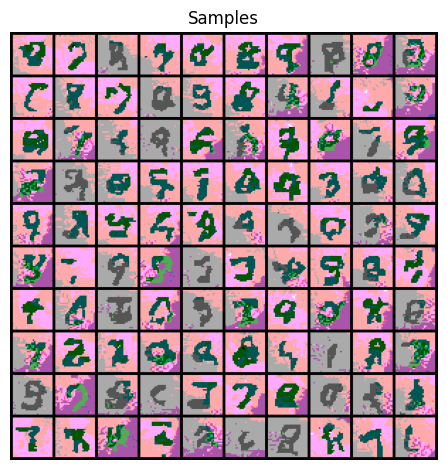

In [15]:
q3ab_save_results(2, 'b', q3_b)

## Part (c) K, V Caching for Improved Inference
You may have noticed that generation from the transformer is quite slow. Part of this is just due to the autoregressive nature. However, another part is due to some computational inefficiency. At each forward pass of the model, we are performing repeat computation of the past sequence. Specifically, we can cache the key and values at the multi attention layer to more quickly predict at each step.

In self-attention, a sequence is processed by generating three vectors for each element in the sequence: a Query (Q), a Key (K), and a Value (V). These vectors are then used to compute attention scores and subsequently the output of the attention layer.
Mathematically, this can be represented as:
 * For each index $i$, compute $Q_i$, $K_i$, $V_i$ for the current element
 * Retrieve $K_{<i}$ and $V_{<i}$ from the cache (where $<i$ denotes all indices before the current one)
 * Compute the attention output using $Q_i$, $[K_{<i}, K_i]$, $[V_{<i}, V_i]$


Next implement caching for your transformer to make inference more efficient by modifying your self attention. Use caching for inference in the future problems for faster generation! (Note caching is only used during inference). You will use the same dataset as in part B, dataset 2 of this question (colored mnist). No training is required in this section, feel free to reuse the model you trained in part B, dataset 2.

**You will provide these deliverables**

1. Over the course of inference, measure the time for the forward pass over the total sequence length with and without caching.
3. 100 samples from the final trained model using the caching inference pipeline.



In [20]:
def q3_c(train_data, test_data, image_shape, dset_id):
    import os
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# sampling steps,) numpy array of time per sampling iteration, without caching
    - a (# sampling steps,) numpy array of time per sampling iteration, with caching
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3} (sample generated without caching)
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3} (sample generated with caching)
    """
    # Model hyperparameters
    batch_size = 64
    learning_rate = 1e-3
    num_epochs = 15
    
    # Transformer architecture parameters
    d_model = 128
    n_heads = 4
    n_layers = 2
        
    H, W, C = image_shape
    print("image shape: ", image_shape)
    sequence_length = H * W + 1  # +1 for <bos> token
    vocab_size = 64  # each pixel represented by 6 bits
    
    # Create datasets and data loaders
    train_loader = create_dataset(train_data, image_shape, batch_size)
    test_loader = create_dataset(test_data, image_shape, batch_size)
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load or train the model
    model = iGPT(vocab_size, sequence_length, d_model, n_heads, n_layers).to(device)
    train_losses, test_losses = train_igpt(model, train_loader, test_loader, 
                                            sequence_length, vocab_size, device,
                                            num_epochs, learning_rate)
 

    
    # Generate samples without caching and measure time
    # start_time = time.time()
    samples_no_cache, time_list_no_cache = generate_samples(model, sequence_length, vocab_size, image_shape, device, use_cache=False, test_mode=False)
    
    # Generate samples with caching and measure time
    samples_with_cache, time_list_with_cache = generate_samples(model, sequence_length, vocab_size, image_shape, device, use_cache=True, test_mode=False)
    # print(f"Speedup: {total_time_no_cache / total_time_with_cache:.2f}x")
    

    return time_list_no_cache, time_list_with_cache, samples_no_cache, samples_with_cache

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
image shape:  (28, 28, 3)
Epoch 1/15, Batch 0/938, Loss: 4.2718
Epoch 1/15, Batch 50/938, Loss: 3.5423
Epoch 1/15, Batch 100/938, Loss: 1.7781
Epoch 1/15, Batch 150/938, Loss: 1.1359
Epoch 1/15, Batch 200/938, Loss: 0.9425
Epoch 1/15, Batch 250/938, Loss: 0.8162
Epoch 1/15, Batch 300/938, Loss: 0.8538
Epoch 1/15, Batch 350/938, Loss: 0.7669
Epoch 1/15, Batch 400/938, Loss: 0.7949
Epoch 1/15, Batch 450/938, Loss: 0.7809
Epoch 1/15, Batch 500/938, Loss: 0.7572
Epoch 1/15, Batch 550/938, Loss: 0.7087
Epoch 1/15, Batch 600/938, Loss: 0.6779
Epoch 1/15, Batch 650/938, Loss: 0.6718
Epoch 1/15, Batch 700/938, Loss: 0.6426
Epoch 1/15, Batch 750/938, Loss: 0.6188
Epoch 1/15, Batch 800/938, Loss: 0.6319
Epoch 1/15, Batch 850/938, Loss: 0.6013
Epoch 1/15, Batch 900/938, Loss: 0.6063
Epoch 1/15 completed. Test Loss: 0.5818
Epoch 2/15, Batch 0/938, Loss: 0.5846
Epoch 2/15, Batch 50/938, Loss: 0.5855
Epoch 2/15, Batch 100/938, Loss: 0.5834

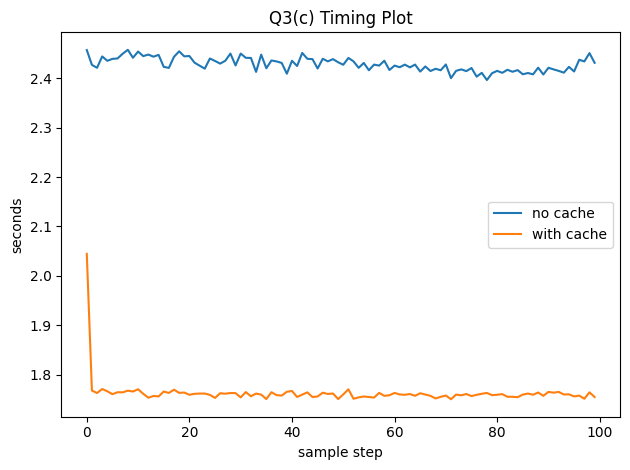

samples shape:  (100, 28, 28, 3)


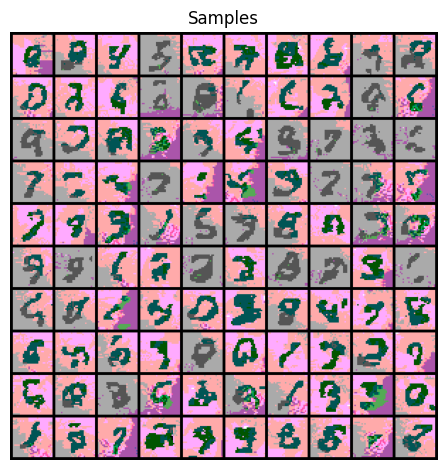

samples shape:  (100, 28, 28, 3)


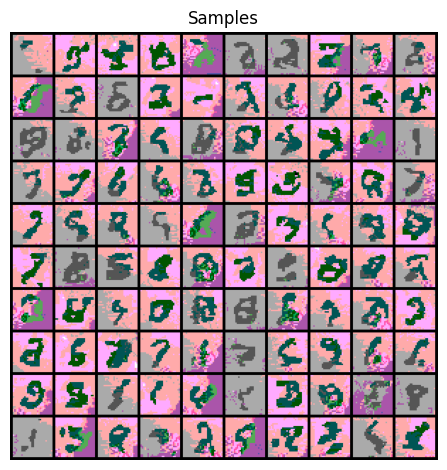

In [21]:
q3c_save_results(2, q3_c)

# Question 4: Causal Transformer: Tokenized Images

## Image Tokenization with Vector Quanization

## Part (a) Image Quantization

Above, we implemented iGPT, which autoregressivly predicts raw pixels. Transformers have quadratic complexity in the sequence length which prevents this naive approach from scaling well to large images.

The space of natural images often contains very correlated information. This suggests we can learn a reduced representation. VQVAE is a method that does just that, learning to map images to a more compact discrete set of tokens. We will cover this method in more detail in future lectures. The only thing you need to know now is that we can learn an encoder (and corresponding decoder), which can extract a discrete representation from an image. 

If you are curious, checkout the VQVAE paper to learn more: https://arxiv.org/abs/1711.00937 (we will cover this in a future lecture though!)

In this part, we provide a pre-trained VQVAE model, which consists of:
 * encoder to tokenize the images
 * the decoder to recover the image
 * a token vocabulary of VQVAE_MODEL.n_embeddings

Below is the code for loading the VQ model. Note that VQVAE encoding process is lossy, so the decoded images will not be the exact same as the input. Some blurriness in the recovered image is to be expected. The docstrings of the relevant methods you will need for the VQVAE_MODEL are provided below for your convenience. 

We will use 2 colored mnist datasets in this part. The first is the same dataset used in previous parts. The second, hads a colored digit on a differently colored background. We will call these datasets Colored MNIST and Colored MNIST v2. Note that the vqvae is trained per dataset.

**You will provide these deliverables**

1. Use the provided encoder model to quantize the images then inspect the recovered images by applying the decoder for each of the two datasets

In [22]:
# @property
# def n_embeddings(self) -> int:
#     """The size of the token vocabulary"""
#    
# def quantize(self, x: np.ndarray) -> np.ndarray:
#     """Quantize an image x.
#
#     Args:
#         x (np.ndarray, dtype=int): Image to quantize. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#
#     Returns:
#         np.ndarray: Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings]
#     """
#    
# def decode(self, z_index: np.ndarray) -> np.ndarray:
#     """Decode a quantized image.
#
#     Args:
#         z_index (np.ndarray, dtype=int): Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings].
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#     """
# 

In [23]:
def q4_a(images, vqvae):
    """
    images: (B, H, W, C), the images to pass through the encoder and decoder of the vqvae
    vqvae: a vqvae model, trained on the relevant dataset

    Returns
    - a numpy array of size (2, H, W, C) of the decoded image
    """
    print(vqvae.n_embeddings)
    
    quantized_images = vqvae.quantize(images)
    # print shape of quantized_images
    print("quantinzed images:", quantized_images)
    print("quantized_images shape: ", quantized_images.shape)
    autoencoded_images = vqvae.decode(quantized_images)
    return autoencoded_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.061281282..1.1016651].


data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
1024
quantinzed images: tensor([[[ 161,  198,  121,  218,  645,  171,  272],
         [ 264,  191,  110,  193,  844,  334,  440],
         [ 935,  730,  386, 1020,  657,  218,  260],
         [ 145,  544,  730,  835,  702,  508,   96],
         [1014,  134,  722,  906,  738,  697,  811],
         [ 884,  268,  165,   94,  952,  821,  346],
         [ 228,  647,  429,  722,  982,  872,  582]],

        [[ 579,  228,  811,  219,  811,  569,   57],
         [ 749,  699,   11,  305,  925,  830,  395],
         [ 145,  593,  907,  422,  421,  533,  130],
         [ 769,  429,  342,  201,  261,  309,  348],
         [ 272,  609,  409,  884,  253,   19,  643],
         [ 250,  740,  465,  253,  772,  264,  228],
         [ 376,  534,  832,   18,  922,  134,  354]]])
quantized_images shape:  torch.Size([2, 7, 7])
samples shape:  (4, 28, 28, 3)


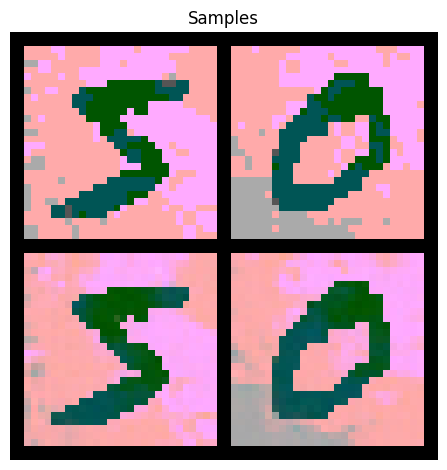

In [24]:
q4a_save_results(1, q4_a)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08431109..1.1520311].


data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
1024
quantinzed images: tensor([[[288,  75, 641,  75, 907, 907, 288],
         [402, 964, 265, 636, 425, 427, 402],
         [907, 993, 616, 504, 847, 718, 402],
         [ 75, 896, 883, 274, 888, 288, 421],
         [ 75, 641, 964, 419, 432, 421, 421],
         [336, 451, 859, 904, 117, 402, 288],
         [117, 694, 330, 336, 402, 288, 421]],

        [[334, 779, 334, 226, 637, 779, 242],
         [637, 950, 132, 914, 922, 802, 779],
         [179, 253, 651, 167, 937, 713, 779],
         [779, 675, 231, 132, 179, 939, 253],
         [779, 928, 380, 435, 369, 136, 468],
         [779, 928, 939, 859, 211, 625, 637],
         [779, 334, 309, 435, 242, 468, 637]]])
quantized_images shape:  torch.Size([2, 7, 7])
samples shape:  (4, 28, 28, 3)


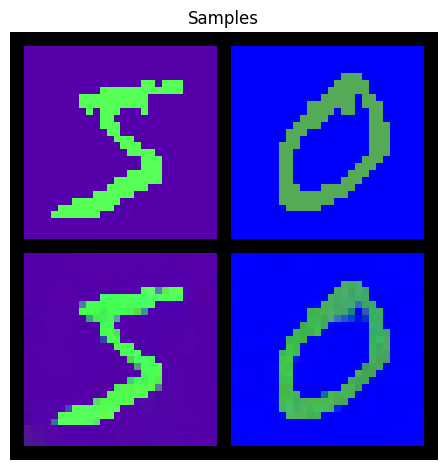

In [25]:
q4a_save_results(2, q4_a)

## Part (b) Autoregressive Transformer on Colored Shapes and MNIST with Vector Quantization

We can use the VQVAE to tokenize an image dataset. This will result in a much smaller sequence length than the approach we tried in Question 3(b). For this part, train a transformer on the dataset tokenized by the VQVAE.

This is a simplified version of the approach used in VQGAN [VQGAN](https://arxiv.org/abs/2012.09841) -> Section 3.2: Learning the Composition of Images with Transformers (Again, we will cover this in more detail in a future lecture!)

Update the following hyperparameters:
* layers: 4 (we can train a bigger transformer now since less memory is used per input!)
* 30 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model

In [26]:
def create_tokenized_data(data, image_shape, batch_size, vqvae):
    H ,W ,C = image_shape
    data_tokens = vqvae.quantize(data)
    data_tokens = np.reshape(data_tokens, (data_tokens.shape[0], 7, 7))
    data_flat = np.reshape(data_tokens, (data_tokens.shape[0], -1)) # (batch_size, 49)
    
    dataset = torch.utils.data.TensorDataset(data_flat)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [27]:
def q4_b(train_data, test_data, image_shape, dset_id, vqvae):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets
    vqvae: a vqvae model, trained on dataset dset_id

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
    """
    
    H, W, C = image_shape
    # initialize hyperparameters
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 30
    d_model = 128
    n_heads = 4
    n_layers = 4
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # determine sequence length and vocab size
    sequence_length = 7 * 7 + 1  # +1 for <bos> token
    vocab_size = vqvae.n_embeddings
    
    # create dataloaders
    train_loader = create_tokenized_data(train_data, image_shape, batch_size, vqvae)
    test_loader = create_tokenized_data(test_data, image_shape, batch_size, vqvae)
    
    # test the dataloader

    model = iGPT(vocab_size, sequence_length, d_model, n_heads, n_layers).to(device)
    
    train_losses, test_losses = train_igpt(model, train_loader, test_loader, 
                                            sequence_length, vocab_size, device,
                                            num_epochs, learning_rate)
    token_image_shape = (7,7,1)
    samples, _ = generate_samples(model, sequence_length, vocab_size, token_image_shape, device)
    # decode the samples
    print("samples shape: ", samples.shape)
    samples = samples.squeeze(-1)
    print("samples shape: ", samples.shape)
    samples = vqvae.decode(samples)
    
    return train_losses, test_losses, samples

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
Epoch 1/30, Batch 0/469, Loss: 7.1077
Epoch 1/30, Batch 50/469, Loss: 6.9837
Epoch 1/30, Batch 100/469, Loss: 6.3427
Epoch 1/30, Batch 150/469, Loss: 5.9725
Epoch 1/30, Batch 200/469, Loss: 5.8723
Epoch 1/30, Batch 250/469, Loss: 5.5979
Epoch 1/30, Batch 300/469, Loss: 5.3181
Epoch 1/30, Batch 350/469, Loss: 5.1249
Epoch 1/30, Batch 400/469, Loss: 4.9939
Epoch 1/30, Batch 450/469, Loss: 4.9383
Epoch 1/30 completed. Test Loss: 4.8370
Epoch 2/30, Batch 0/469, Loss: 4.8403
Epoch 2/30, Batch 50/469, Loss: 4.7477
Epoch 2/30, Batch 100/469, Loss: 4.7367
Epoch 2/30, Batch 150/469, Loss: 4.7285
Epoch 2/30, Batch 200/469, Loss: 4.6845
Epoch 2/30, Batch 250/469, Loss: 4.6479
Epoch 2/30, Batch 300/469, Loss: 4.5854
Epoch 2/30, Batch 350/469, Loss: 4.5794
Epoch 2/30, Batch 400/469, Loss: 4.5112
Epoch 2/30, Batch 450/469, Loss: 4.4655
Epoch 2/30 completed. Test Loss: 4.3398
Epoc

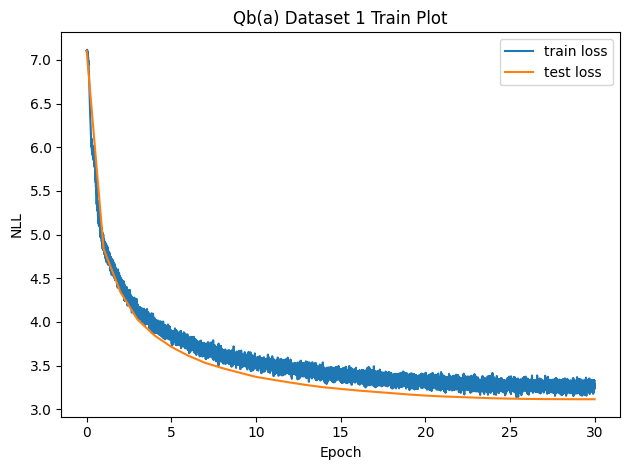

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13376339..1.283002].


samples shape:  (100, 28, 28, 3)


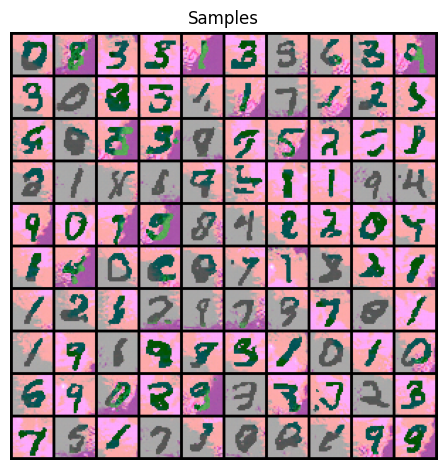

In [28]:
q4b_save_results(1, q4_b)

data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
Epoch 1/30, Batch 0/469, Loss: 7.1028
Epoch 1/30, Batch 50/469, Loss: 7.0020
Epoch 1/30, Batch 100/469, Loss: 6.5681
Epoch 1/30, Batch 150/469, Loss: 6.2534
Epoch 1/30, Batch 200/469, Loss: 5.9077
Epoch 1/30, Batch 250/469, Loss: 5.1703
Epoch 1/30, Batch 300/469, Loss: 4.6615
Epoch 1/30, Batch 350/469, Loss: 4.3008
Epoch 1/30, Batch 400/469, Loss: 4.2373
Epoch 1/30, Batch 450/469, Loss: 4.1927
Epoch 1/30 completed. Test Loss: 4.0851
Epoch 2/30, Batch 0/469, Loss: 4.1059
Epoch 2/30, Batch 50/469, Loss: 4.0950
Epoch 2/30, Batch 100/469, Loss: 4.1215
Epoch 2/30, Batch 150/469, Loss: 4.1579
Epoch 2/30, Batch 200/469, Loss: 3.9415
Epoch 2/30, Batch 250/469, Loss: 3.9819
Epoch 2/30, Batch 300/469, Loss: 3.9069
Epoch 2/30, Batch 350/469, Loss: 4.0260
Epoch 2/30, Batch 400/469, Loss: 3.9660
Epoch 2/30, Batch 450/469, Loss: 3.9541
Epoch 2/30 completed. Test Loss: 3.8060
Epoc

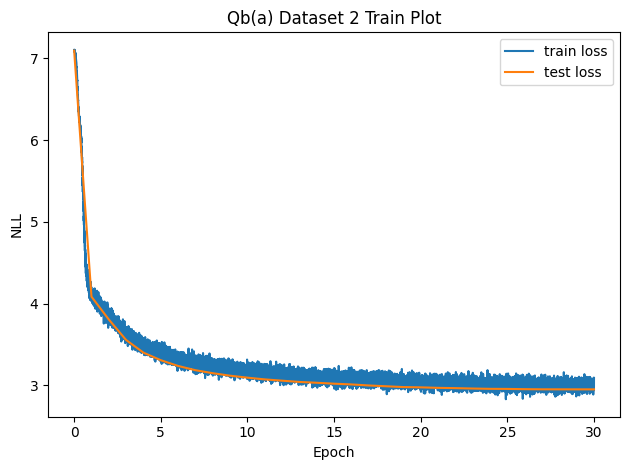

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23252869..1.2633749].


samples shape:  (100, 28, 28, 3)


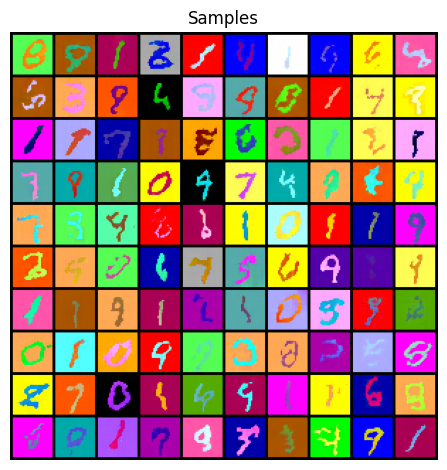

In [29]:
q4b_save_results(2, q4_b)

# Question 5: Causal Transformer: Text

Now lets consider text! You are probably already fimilar with autoregressive transformers for text, now more commonly known as Large Language Modesl (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

In [2]:
data = visualize_q5_data()

data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
Sample 1
E.E. Cummings, [as freedom is a breakfastfood] from Complete Poems 1904-1962, edited by George J. Firmage. Copyright 1926, 1954, 1991 by the Trustees for the E.E. Cummings Trust. Copyright  1985 by George James Firmage. Reprinted with the permission of Liveright Publishing Corporation.
--------------------------------------------------------------------------------

Sample 2
The moon has left the sky, love,
The stars are hiding now,
And frowning on the world, love,
Night bares her sable brow.

The snow is on the ground, love,
And cold and keen the air is.
Im singing here to you, love;
Youre dreaming there in Paris.

But this is Natures law, love,
Though just it may not seem,
That men should wake to sing, love;
While maidens sleep and dream.

Them care may not molest, love,
Nor stir them from their slumbers,
Though midnight find the swain, love.
Still halting oer his numbers.

I watch the rosy dawn, love,
Come stealin

## Part (a) Modeling Text
Train a transformer on the poetry dataset.

Data Preprocessing:
* We will use a simple method to tokenize the data. We will convert each unique character into a token. (Current LLMs use more sophisticated tokenizers, most commonly, [byte-pair encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt))
* Previously we have leveraged a **\<bos\>** as part of the model, just like iGPT. For text, we may not always sample a sequence that starts at the beginning. Instead, we will add the **\<bos\>** token to the beginning of every sequence in the dataset, and remove the **\<bos\>** token from the model.
* Another problem is that the model must know when to stop sampling. This is done by appending an **\<eos\>**, or end of sequence token at the end of every sequence in the dataset.
* We can now convert the sequence into subsequences of size context_length, for training!

We recommend the following hyperparameters:
* Sequence length: 128
* 5 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. Provide **5 unconditional samples** of **128 characters** showcasing the model text generation capabilities (text samples should stop after **\<eos\>**. Text after **\<eos\>** can be removed in post processing)

In [15]:
import torch
from torch.utils.data import Dataset

class Tokenizer:
    def __init__(self, texts):
        # Create a set of all unique characters across all texts
        all_chars = set()
        for text in texts:
            all_chars.update(text)
        
        # Sort characters for consistent mapping
        all_chars = sorted(all_chars)
        
        self.char_to_id = {char: i + 2 for i, char in enumerate(all_chars)}
        self.id_to_char = {i + 2: char for i, char in enumerate(all_chars)}
        
        self.bos_token = 0
        self.eos_token = 1
        
        self.char_to_id['<bos>'] = self.bos_token
        self.char_to_id['<eos>'] = self.eos_token
        self.id_to_char[self.bos_token] = '<bos>'
        self.id_to_char[self.eos_token] = '<eos>'
        
        self.vocab_size = len(self.char_to_id)
    
    def encode(self, text):
        tokens = [self.char_to_id[char] for char in text]
        tokens.insert(0, self.bos_token)
        tokens.append(self.eos_token)
        return torch.tensor(tokens)
    
    def decode(self, tokens):
        chars = [self.id_to_char[token] for token in tokens if token != self.bos_token and token != self.eos_token]
        # remove the special tokens
        chars = [char for char in chars if char != '<bos>' and char != '<eos>']
        return ''.join(chars)

class TextData(Dataset): 
    def __init__(self, texts, tokenizer, sequence_length):
        self.tokenizer = tokenizer
        self.sequence_length = sequence_length
        
        # Tokenize all texts with BOS and EOS tokens
        self.sequences = []
        for text in texts:
            # Encode the text (this adds BOS and EOS)
            tokens = tokenizer.encode(text)
            stride = 1
            if len(tokens) > sequence_length:
                for i in range(0, len(tokens) - sequence_length + 1, stride):
                    self.sequences.append(tokens[i:i + sequence_length])
            # else:
            #     # Drop the shorter sequences
            #     padded = torch.full((sequence_length,), self.tokenizer.eos_token, dtype=tokens.dtype)
            #     padded[:len(tokens)] = tokens
            #     self.sequences.append(padded)

    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, index):
        return self.sequences[index]
    
from torch.utils.data import Dataset, DataLoader

# Then in your function:
def create_text_data_loader(texts, sequence_length, tokenizer, batch_size):
    dataset = TextData(texts, tokenizer, sequence_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [19]:
# text model architecture version

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        """
        q: (batch_size, n_heads, seq_len, head_size)
        k: (batch_size, n_heads, seq_len, head_size)
        v: (batch_size, n_heads, seq_len, head_size)
        """
        d_k = q.shape[-1]
        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(d_k)  # (batch_size, n_heads, seq_len, seq_len)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = torch.softmax(scores, dim=-1)  # (batch_size, n_heads, seq_len, seq_len)
        attention_weights = self.dropout(attention_weights)  # (batch_size, n_heads, seq_len, seq_len)

        output = torch.matmul(attention_weights, v)  # (batch_size, n_heads, seq_len, head_size)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.0, cache=False):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_size = d_model // n_heads
        self.use_cache = cache

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        self.out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.attention = ScaledDotProductAttention(dropout=dropout)
        self.cached_k = None
        self.cached_v = None

    def split_heads(self, x):
        """
        x: (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, d_model = x.shape
        return x.view(batch_size, seq_len, self.n_heads, self.head_size).transpose(1, 2)  # (batch_size, n_heads, seq_len, head_size)
    
    def combine_heads(self, x):
        """
        x: (batch_size, n_heads, seq_len, head_size)
        """
        batch_size, n_heads, seq_len, head_size = x.shape
        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)  # (batch_size, seq_len, d_model)
    
    def forward(self, x, mask=None, use_cache=False, past_key_values=None):
        batch_size, seq_len, d_model = x.shape
        if past_key_values is not None:
            self.cached_k, self.cached_v = past_key_values
        q = self.W_q(x)  # (batch_size, seq_len, d_model)
        k = self.W_k(x)
        v = self.W_v(x)

        q = self.split_heads(q)  # (batch_size, n_heads, seq_len, head_size)
        k = self.split_heads(k)
        v = self.split_heads(v)
        
        # Use KV cache if enabled
        if use_cache and self.cached_k is not None and self.cached_v is not None:
            # Concatenate current k, v with cached k, v
            k = torch.cat([self.cached_k, k], dim=2)
            v = torch.cat([self.cached_v, v], dim=2)


            self.cached_k = k
            self.cached_v = v
        
        # Create causal mask if needed
        if mask is None:
            # If using cache, adjust mask to account for the full sequence length
            full_seq_len = k.size(2)
            # For cached version, we need to adjust the mask to allow attention to all past tokens
            if use_cache and self.cached_k is not None:
                # Create a mask where current tokens can attend to all previous tokens
                # Current sequence position is at seq_len
                seq_position = seq_len
                # Create a mask that allows each token to see itself and all previous tokens
                mask = torch.ones(seq_len, full_seq_len).to(x.device)
                # Make it causal by setting future positions to 0
                mask[:, seq_position:] = 0
            else:
                # Standard causal mask for the full sequence
                mask = torch.tril(torch.ones(full_seq_len, full_seq_len)).to(x.device)
            
            mask = mask.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, seq_len)

        # Use the attention module directly
        output = self.attention(q, k, v, mask)  # (batch_size, n_heads, seq_len, head_size)
        
        # Combine heads
        output = self.combine_heads(output)  # (batch_size, seq_len, d_model)
        past_key_values = (k, v)
        if use_cache:
            return self.dropout(self.out(output)) , past_key_values
        else:
            return self.dropout(self.out(output))
    
    def clear_cache(self):
        self.cached_k = None
        self.cached_v = None
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1, use_cache=False):
        super().__init__()
        self.masked_mha = MultiHeadAttention(d_model, n_heads, dropout, cache=use_cache)
        self.layer_norm1 = nn.LayerNorm(d_model)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),  
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, use_cache=False, past_key_values=None):

        # Self-attention with residual connection and layer normalization
        residual = x
        x = self.layer_norm1(x)  # Pre-norm architecture
        if use_cache and past_key_values is not None:
            x, past_key_values = self.masked_mha(x, use_cache=use_cache, past_key_values=past_key_values)
        else:
            x = self.masked_mha(x)
            
        x = residual + x  # Residual connection
        
        # Feed forward with residual connection and layer normalization
        residual = x
        x = self.layer_norm2(x)  # Pre-norm architecture
        x = self.feed_forward(x)
        x = residual + x  # Residual connection
        if use_cache:
            return x , past_key_values
        else:
            return x
    
    def clear_cache(self):
        self.masked_mha.clear_cache()

class iGPT(nn.Module):
    def __init__(self, vocab_size, context_length, d_model, n_heads, n_layers, dropout=0.1, use_cache=False):
        super().__init__()
        self.vocab_size = vocab_size
        self.context_length = context_length
        self.d_model = d_model
        self.n_heads = n_heads  
        self.n_layers = n_layers
        self.dropout = dropout
        self.use_cache = use_cache
        
        # Token embedding
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional embedding (learned, as per iGPT specs)
        self.position_embedding = nn.Embedding(context_length, d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Stack of decoder layers
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, dropout, use_cache=use_cache) 
            for _ in range(n_layers)
        ])
        
        # Final layer norm
        self.layer_norm = nn.LayerNorm(d_model)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)

    def forward(self, x, past_key_values=None, use_cache=False):
        # x shape: (batch_size, seq_len)
        batch_size, seq_len = x.shape
        device = x.device
        
        # Create position indices
        positions = torch.arange(0, seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)
        
        # Get embeddings
        token_emb = self.token_embedding(x)  # (batch_size, seq_len, d_model)
        pos_emb = self.position_embedding(positions)  # (batch_size, seq_len, d_model)
        
        # Combine embeddings
        x = token_emb + pos_emb  # (batch_size, seq_len, d_model)
        x = self.dropout(x)
        
        # Apply decoder layers
        past_key_values = None
        for layer in self.decoder_layers:
            if use_cache:
                x, past_key_values = layer(x, use_cache=use_cache, past_key_values=past_key_values)
            else:
                x = layer(x)
        
        # Apply final layer norm
        x = self.layer_norm(x)  # (batch_size, seq_len, d_model)
        
        # Project to vocabulary
        logits = self.output_projection(x)  # (batch_size, seq_len, vocab_size)
        if use_cache:
            return logits, past_key_values
        else:
            return logits
    
    def clear_cache(self):
        for layer in self.decoder_layers:
            layer.clear_cache()

In [20]:
import math

def create_dataset(data, image_shape, batch_size):
    """
    Converts image data to token sequences and creates PyTorch DataLoader.
    
    Args:
        data: A (n_samples, H, W, C) uint8 numpy array of images
        image_shape: (H, W, C) tuple specifying image dimensions
        batch_size: Batch size for DataLoader
        
    Returns:
        DataLoader object with tokenized image sequences
    """
    H, W, C = image_shape
    
    # Convert RGB pixels to single tokens (4 values per channel = 64 possible values)
    # Shape: (n_samples, H, W, C) -> (n_samples, H, W)
    if C == 3:
        # Convert RGB values to a single token: r*16 + g*4 + b
        # Each channel has values in {0,1,2,3}, so we can encode as a single number 0-63
        data_tokens = (data[:,:,:,0] * 16 + data[:,:,:,1] * 4 + data[:,:,:,2])
    else:
        # For grayscale, just use the values directly
        data_tokens = data.reshape(-1, H, W)
    
    # Flatten spatial dimensions to create sequences
    # Shape: (n_samples, H, W) -> (n_samples, H*W)
    data_flat = data_tokens.reshape(-1, H * W)
    
    # Convert to PyTorch tensors
    dataset = torch.utils.data.TensorDataset(torch.tensor(data_flat, dtype=torch.long))
    
    # Create data loader
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

def evaluate_model(model, data_loader, sequence_length, vocab_size, device):
    """
    Evaluates model performance on a dataset.
    
    Args:
        model: The iGPT model
        data_loader: DataLoader containing tokenized images
        sequence_length: Length of token sequences including <bos>
        vocab_size: Size of vocabulary
        device: Device to run evaluation on
        
    Returns:
        Average loss (negative log-likelihood) per dimension
    """
    model.eval()
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)  # Shape: (batch_size, sequence_length-1)
            batch_size = data.size(0)
            
            input_seq = data[:, :-1]
            targets = data[:, 1:]
            
            # Forward pass
            logits = model(input_seq)  # Remove last position's prediction
            
            # Compute loss
            loss = F.cross_entropy(logits.reshape(-1, vocab_size), targets.reshape(-1), reduction='sum')
            
            total_loss += loss.item()
            total_samples += batch_size * (sequence_length - 1)
    
    return total_loss / total_samples



def train_igpt(model, train_loader, test_loader, sequence_length, vocab_size, 
               device, num_epochs, learning_rate):
    """
    Trains the iGPT model.
    
    Args:
        model: The iGPT model to train
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        sequence_length: Length of token sequences including <bos>
        vocab_size: Size of vocabulary
        device: Device to train on
        num_epochs: Number of training epochs
        learning_rate: Initial learning rate
        
    Returns:
        train_losses: Array of training losses per minibatch
        test_losses: Array of test losses per epoch
    """
    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler with warmup and cosine decay
    warmup_steps = 100
    total_steps = len(train_loader) * num_epochs
    
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            decay_ratio = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    # Initialize arrays to store losses
    train_losses = []
    test_losses = [evaluate_model(model, test_loader, sequence_length, vocab_size, device)]
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        batch_idx = 0
        for data in train_loader:
            batch_idx += 1
            data = data.to(device)  # Shape: (batch_size, sequence_length)
            
            # Shape: (batch_size, sequence_length-1)
            input_seq = data[:, :-1]
            targets = data[:, 1:]
            
            # Forward pass
            logits = model(input_seq)
            targets = targets.to(device)
            
            loss = F.cross_entropy(logits.reshape(-1, vocab_size), targets.reshape(-1))
            # print(f"loss: {loss.item():.4f}")
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # Record loss
            train_losses.append(loss.item())
            
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        # Evaluate on test set after each epoch
        test_loss = evaluate_model(model, test_loader, sequence_length, vocab_size, device)
        test_losses.append(test_loss)
        print(f"Epoch {epoch+1}/{num_epochs} completed. Test Loss: {test_loss:.4f}")
    return np.array(train_losses), np.array(test_losses)


In [21]:
def generate_text_samples(model, tokenizer, max_length, device, num_samples=10, temperature=1.0, use_cache=False):
    """
    Generates text samples from the trained model.
    
    Args:
        model: The trained language model
        tokenizer: The tokenizer used to encode/decode text
        max_length: Maximum length of the generated sequence (including BOS/EOS)
        device: Device to run generation on
        num_samples: Number of samples to generate
        temperature: Controls randomness (lower = more deterministic)
        use_cache: Whether to use caching for faster sampling
        
    Returns:
        List of generated text samples and a list of generation times
    """
    model.eval()
    samples = []
    import time
    time_list = []
    
    with torch.no_grad():
        for _ in range(num_samples):
            start_time = time.time()
            
            # Start with just the BOS token
            current_seq = torch.tensor([[tokenizer.bos_token]], dtype=torch.long, device=device)
            
            # Cache for key-value pairs if using caching
            past_key_values = None
            
            # Autoregressive generation - one token at a time
            for _ in range(max_length - 1):  # -1 because we already have BOS
                if use_cache and past_key_values is not None:
                    # Only need to process the new token with cached key-values
                    logits, past_key_values = model(
                        current_seq[:, -1:],
                        past_key_values=past_key_values, 
                        use_cache=True
                    )
                    logits = logits[:, -1, :]  # Get prediction for current position
                else:
                    # Process the entire sequence
                    if use_cache:
                        logits, past_key_values = model(current_seq, use_cache=True)
                        logits = logits[:, -1, :]  # Get prediction for current position
                    else:
                        logits = model(current_seq)
                        logits = logits[:, -1, :]  # Get prediction for last position
                
                # Apply temperature
                if temperature != 1.0:
                    logits = logits / temperature
                
                # Sample from the probability distribution
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, 1)
                
                # Append new token to sequence
                current_seq = torch.cat([current_seq, next_token], dim=1)
                
                # Stop if EOS token is generated
                if next_token.item() == tokenizer.eos_token:
                    break
            
            # Decode the generated sequence
            generated_tokens = current_seq[0].cpu().tolist()
            generated_text = tokenizer.decode(generated_tokens)
            samples.append(generated_text)
            
            end_time = time.time()
            time_list.append(end_time - start_time)
    
    return samples, np.array(time_list)

In [22]:
import torch.utils.data as data
def q5_a(train_text, test_text):
  """
  train_text: list[str] Train text sequences.
  test_text: list[str] Test text sequences.

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a list of 5 (str), 5 generated samples from the model.
  """
  sequence_length = 128
  epochs = 5
  learning_rate = 1e-3
  d_model = 128  
  n_heads = 4    
  n_layers = 6   
  batch_size = 1024
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
  tokenizer = Tokenizer(train_text)
  vocab_size = tokenizer.vocab_size

  train_loader = create_text_data_loader(train_text, sequence_length, tokenizer, batch_size)
  test_loader = create_text_data_loader(test_text, sequence_length, tokenizer, batch_size)
  
  
  model = iGPT(vocab_size, sequence_length, d_model, n_heads, n_layers).to(device)
  train_losses, test_losses = train_igpt(model, train_loader, test_loader, sequence_length, vocab_size, device, epochs, learning_rate)
  
  text_samples, _ = generate_text_samples(model, tokenizer, sequence_length, device, num_samples=5)
  return train_losses, test_losses, text_samples

### Results

Once you've implemented `q5_a`, execute the cells below to visualize and save your results



data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data


Epoch 1/5, Batch 50/477, Loss: 2.8145
Epoch 1/5, Batch 100/477, Loss: 2.4764
Epoch 1/5, Batch 150/477, Loss: 2.3922
Epoch 1/5, Batch 200/477, Loss: 2.3275
Epoch 1/5, Batch 250/477, Loss: 2.2068
Epoch 1/5, Batch 300/477, Loss: 2.0961
Epoch 1/5, Batch 350/477, Loss: 2.0128
Epoch 1/5, Batch 400/477, Loss: 1.9417
Epoch 1/5, Batch 450/477, Loss: 1.8972
Epoch 1/5 completed. Test Loss: 1.8999
Epoch 2/5, Batch 50/477, Loss: 1.8257
Epoch 2/5, Batch 100/477, Loss: 1.7714
Epoch 2/5, Batch 150/477, Loss: 1.7343
Epoch 2/5, Batch 200/477, Loss: 1.7065
Epoch 2/5, Batch 250/477, Loss: 1.6745
Epoch 2/5, Batch 300/477, Loss: 1.6477
Epoch 2/5, Batch 350/477, Loss: 1.6189
Epoch 2/5, Batch 400/477, Loss: 1.5987
Epoch 2/5, Batch 450/477, Loss: 1.5895
Epoch 2/5 completed. Test Loss: 1.6667
Epoch 3/5, Batch 50/477, Loss: 1.5469
Epoch 3/5, Batch 100/477, Loss: 1.5355
Epoch 3/5, Batch 150/477, Loss: 1.5236
Epoch 3/5, Batch 200/477, Loss: 1.5015
Epoch 3/5, Batch 250/477, Loss: 1.5034
Epoch 3/5, Batch 300/477, Lo

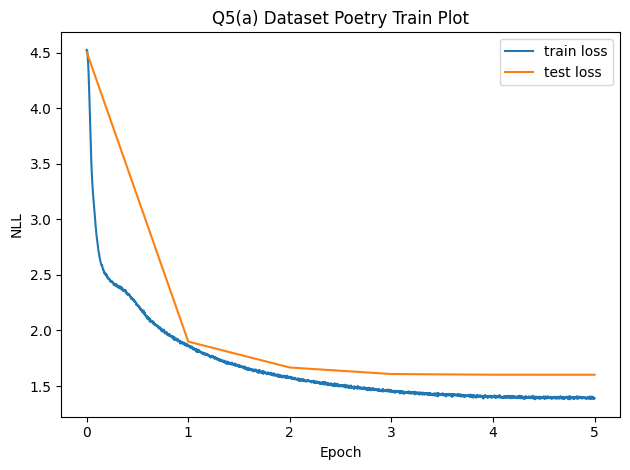

Sample 1
Doe gods "Hen the Spype and "yde with eyes
Not little kins hise outbing through the bair,
And with your bronze younge tongue 

Sample 2
Those dress which forth did golden she
Of heaving in white do:

There she's sprungth,
And thee but them burn.
Sleeps on it

Sample 3
Nymphings love's the long Time, and leaves store;
where your stouth with the floor story-flocks
           To still was forth

Sample 4

He heaven thou be small at like a certain,
With the risely plant that wait
With they death may the Chokall straight-19Kobe,

Sample 5
A from Poetrynel's beast
And so song: from grown and his grace,
Free, which making the eyes content,
Leaves of right, what b



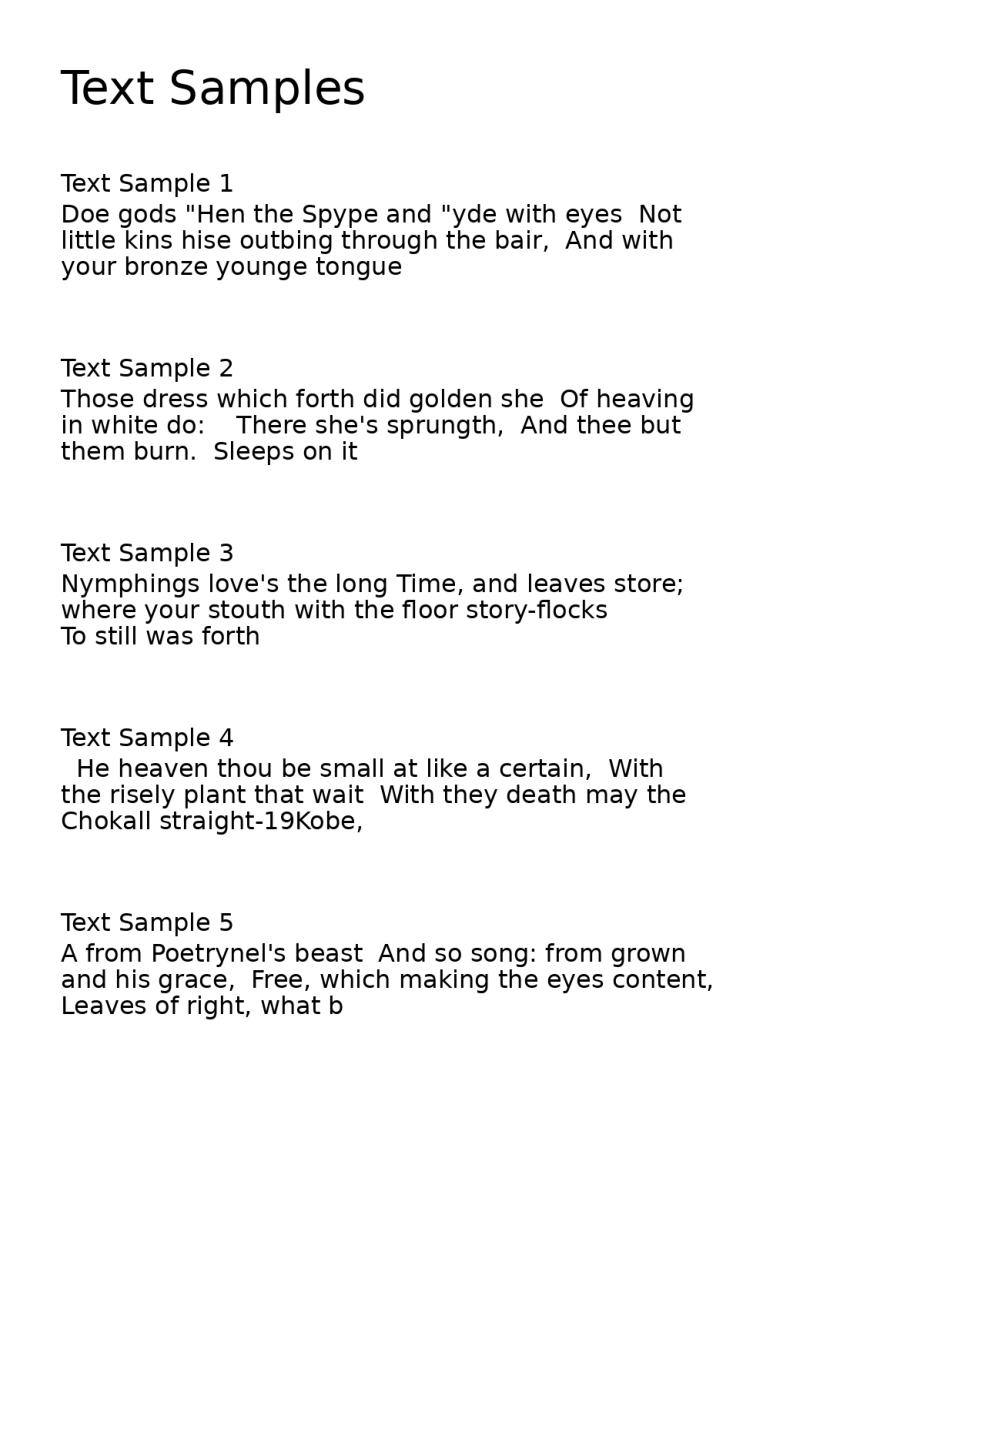

In [23]:
q5a_save_results(q5_a)

# Question 6: Causal Transformer: Multimodal

So far, we have been dealing only with autoregressive generation of a single modality. Now we will train a model that operates on multiple modalities!

We will use the text labeled colored MNIST dataset, which has a text description of the MNIST image. Run the cell below to visualize the data along with the text annotation. This is the Colored MNIST v2 dataset, which also comes with these text labels.

data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data


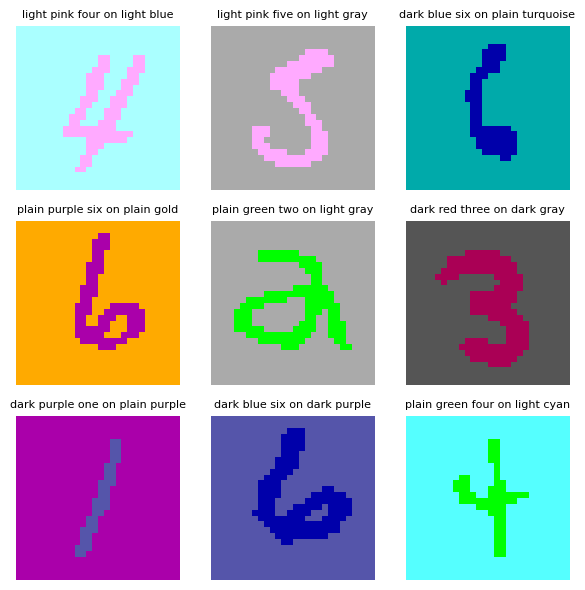

In [29]:
visualize_q6_data()

## Part (a) Multimodal Text and Image Generation
Implement and train an autoregressive (AR) model capable of handling both text and image data. The model should be designed to process sequences composed of concatenated text and image tokens in both orders (text followed by images and images followed by text). Additionally, the model should be capable of generating unconditional text and image samples.

Data Preprocessing:
* Text Tokens: Map each unique word in the text data to a unique token. (Note that all text descriptions contain the exact same amount of words. This simplifies text processing, as you won't have to deal with sequences of different lengths as in Question 5)
* Image Tokens: Quantize the image data into tokens using the VQVAE tokenizer from Problem 4.
* In this problem, we have 2 modalities. Introduce an **\<end of text\>** token and an **\<end of image\>** token. After seeing such a token, the model should switch to sampling the next modality.
* Formulate batches as sequences of concat([**\<end of image\>**, text_tokens, **\<end of text\>**, image_tokens]) and concat([**\<end of text\>**, image_tokens, **\<end of image\>**, text_tokens]). With a 50/50 split between each ordering.

Inference:
* During inference, we cannot mix modality tokens. During sampling we can restrict the logits to only be within the relevant modality.
* After **\<end of image\>**, only allow the model to sample text tokens (including **\<end of text\>**)
* After **\<end of text\>**, only allow the model to sample image tokens (including **\<end of image\>**)
* At the very start (conditioned on the **\<bos\>** token, only allow the model to sample one of (**\<end of image\>** or **\<end of text\>**))
* As the model may not always correctly sample the **\<end of image\>** token before the image ends, you may add a rule to force the model to always sample the correct number of image tokens (49 tokens).

You can use the same hyperparameters as in 4(b) (but of course, feel free to tune your model to achieve better performance)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 9 conditional samples based on provided text.
4. 9 conditional samples based on provided images.
5. 9 unconditional samples showcasing the model's capability in generating standalone text and images.

In [30]:
# multiple model architecture version

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        """
        q: (batch_size, n_heads, seq_len, head_size)
        k: (batch_size, n_heads, seq_len, head_size)
        v: (batch_size, n_heads, seq_len, head_size)
        """
        d_k = q.shape[-1]
        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(d_k)  # (batch_size, n_heads, seq_len, seq_len)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = torch.softmax(scores, dim=-1)  # (batch_size, n_heads, seq_len, seq_len)
        attention_weights = self.dropout(attention_weights)  # (batch_size, n_heads, seq_len, seq_len)

        output = torch.matmul(attention_weights, v)  # (batch_size, n_heads, seq_len, head_size)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.0, cache=False):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_size = d_model // n_heads
        self.use_cache = cache

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        self.out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.attention = ScaledDotProductAttention(dropout=dropout)
        self.cached_k = None
        self.cached_v = None

    def split_heads(self, x):
        """
        x: (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, d_model = x.shape
        return x.view(batch_size, seq_len, self.n_heads, self.head_size).transpose(1, 2)  # (batch_size, n_heads, seq_len, head_size)
    
    def combine_heads(self, x):
        """
        x: (batch_size, n_heads, seq_len, head_size)
        """
        batch_size, n_heads, seq_len, head_size = x.shape
        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)  # (batch_size, seq_len, d_model)
    
    def forward(self, x, mask=None, use_cache=False, past_key_values=None):
        batch_size, seq_len, d_model = x.shape
        if past_key_values is not None:
            self.cached_k, self.cached_v = past_key_values
        q = self.W_q(x)  # (batch_size, seq_len, d_model)
        k = self.W_k(x)
        v = self.W_v(x)

        q = self.split_heads(q)  # (batch_size, n_heads, seq_len, head_size)
        k = self.split_heads(k)
        v = self.split_heads(v)
        
        # Use KV cache if enabled
        if use_cache and self.cached_k is not None and self.cached_v is not None:
            # Concatenate current k, v with cached k, v
            k = torch.cat([self.cached_k, k], dim=2)
            v = torch.cat([self.cached_v, v], dim=2)


            self.cached_k = k
            self.cached_v = v
        
        # Create causal mask if needed
        if mask is None:
            # If using cache, adjust mask to account for the full sequence length
            full_seq_len = k.size(2)
            # For cached version, we need to adjust the mask to allow attention to all past tokens
            if use_cache and self.cached_k is not None:
                # Create a mask where current tokens can attend to all previous tokens
                # Current sequence position is at seq_len
                seq_position = seq_len
                # Create a mask that allows each token to see itself and all previous tokens
                mask = torch.ones(seq_len, full_seq_len).to(x.device)
                # Make it causal by setting future positions to 0
                mask[:, seq_position:] = 0
            else:
                # Standard causal mask for the full sequence
                mask = torch.tril(torch.ones(full_seq_len, full_seq_len)).to(x.device)
            
            mask = mask.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, seq_len)

        # Use the attention module directly
        output = self.attention(q, k, v, mask)  # (batch_size, n_heads, seq_len, head_size)
        
        # Combine heads
        output = self.combine_heads(output)  # (batch_size, seq_len, d_model)
        past_key_values = (k, v)
        if use_cache:
            return self.dropout(self.out(output)) , past_key_values
        else:
            return self.dropout(self.out(output))
    
    def clear_cache(self):
        self.cached_k = None
        self.cached_v = None
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1, use_cache=False):
        super().__init__()
        self.masked_mha = MultiHeadAttention(d_model, n_heads, dropout, cache=use_cache)
        self.layer_norm1 = nn.LayerNorm(d_model)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),  
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, use_cache=False, past_key_values=None):

        # Self-attention with residual connection and layer normalization
        residual = x
        x = self.layer_norm1(x)  # Pre-norm architecture
        if use_cache and past_key_values is not None:
            x, past_key_values = self.masked_mha(x, use_cache=use_cache, past_key_values=past_key_values)
        else:
            x = self.masked_mha(x)
            
        x = residual + x  # Residual connection
        
        # Feed forward with residual connection and layer normalization
        residual = x
        x = self.layer_norm2(x)  # Pre-norm architecture
        x = self.feed_forward(x)
        x = residual + x  # Residual connection
        if use_cache:
            return x , past_key_values
        else:
            return x
    
    def clear_cache(self):
        self.masked_mha.clear_cache()

class iGPT(nn.Module):
    def __init__(self, vocab_size, context_length, d_model, n_heads, n_layers, dropout=0.1, use_cache=False):
        super().__init__()
        self.vocab_size = vocab_size
        self.context_length = context_length
        self.d_model = d_model
        self.n_heads = n_heads  
        self.n_layers = n_layers
        self.dropout = dropout
        self.use_cache = use_cache
        
        # Token embedding
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional embedding (learned, as per iGPT specs)
        self.position_embedding = nn.Embedding(context_length, d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Stack of decoder layers
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, dropout, use_cache=use_cache) 
            for _ in range(n_layers)
        ])
        
        # Final layer norm
        self.layer_norm = nn.LayerNorm(d_model)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)

    def forward(self, x, past_key_values=None, use_cache=False):
        # x shape: (batch_size, seq_len)
        batch_size, seq_len = x.shape
        device = x.device
        
        # Create position indices
        positions = torch.arange(0, seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)
        
        # Get embeddings
        token_emb = self.token_embedding(x)  # (batch_size, seq_len, d_model)
        pos_emb = self.position_embedding(positions)  # (batch_size, seq_len, d_model)
        
        # Combine embeddings
        x = token_emb + pos_emb  # (batch_size, seq_len, d_model)
        x = self.dropout(x)
        
        # Apply decoder layers
        past_key_values = None
        for layer in self.decoder_layers:
            if use_cache:
                x, past_key_values = layer(x, use_cache=use_cache, past_key_values=past_key_values)
            else:
                x = layer(x)
        
        # Apply final layer norm
        x = self.layer_norm(x)  # (batch_size, seq_len, d_model)
        
        # Project to vocabulary
        logits = self.output_projection(x)  # (batch_size, seq_len, vocab_size)
        if use_cache:
            return logits, past_key_values
        else:
            return logits
    
    def clear_cache(self):
        for layer in self.decoder_layers:
            layer.clear_cache()

In [31]:
import math


def evaluate_model(model, data_loader, sequence_length, vocab_size, device):
    """
    Evaluates model performance on a dataset.
    
    Args:
        model: The iGPT model
        data_loader: DataLoader containing tokenized sequences (already includes BOS token)
        sequence_length: Length of token sequences including <bos>
        vocab_size: Size of vocabulary
        device: Device to run evaluation on
        
    Returns:
        Average loss (negative log-likelihood) per dimension
    """
    model.eval()
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)  # Shape: (batch_size, sequence_length)
            batch_size = data.size(0)
            
            # Data already includes BOS token at the beginning
            # Create input sequence (all tokens except the last one)
            input_seq = data[:, :-1]  # Shape: (batch_size, sequence_length-1)
            
            # Create targets (all tokens except the first BOS token)
            targets = data[:, 1:]  # Shape: (batch_size, sequence_length-1)
            
            # Forward pass
            logits = model(input_seq)  # Shape: (batch_size, sequence_length-1, vocab_size)
            
            # Compute loss
            loss = F.cross_entropy(logits.reshape(-1, vocab_size), targets.reshape(-1), reduction='sum')
            
            total_loss += loss.item()
            total_samples += batch_size * (sequence_length - 1)
    
    return total_loss / total_samples



def train_igpt(model, train_loader, test_loader, sequence_length, vocab_size, 
               device, num_epochs, learning_rate):
    """
    Trains the iGPT model.
    
    Args:
        model: The iGPT model to train
        train_loader: DataLoader for training data (already includes BOS token)
        test_loader: DataLoader for test data (already includes BOS token)
        sequence_length: Length of token sequences including <bos>
        vocab_size: Size of vocabulary
        device: Device to train on
        num_epochs: Number of training epochs
        learning_rate: Initial learning rate
        
    Returns:
        train_losses: Array of training losses per minibatch
        test_losses: Array of test losses per epoch
    """
    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler with warmup and cosine decay
    warmup_steps = 1000
    total_steps = len(train_loader) * num_epochs
    
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            decay_ratio = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    # Initialize arrays to store losses
    train_losses = []
    test_losses = [evaluate_model(model, test_loader, sequence_length, vocab_size, device)]
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        
        for (batch_idx,data) in enumerate(train_loader):
            data = data.to(device)  # Shape: (batch_size, sequence_length)
            batch_size = data.size(0)
            
            # Data already includes BOS token at the beginning
            # Create input sequence (all tokens except the last one)
            input_seq = data[:, :-1]  # Shape: (batch_size, sequence_length-1)
            
            # Create targets (all tokens except the first BOS token)
            targets = data[:, 1:]  # Shape: (batch_size, sequence_length-1)
            
            # Forward pass
            logits = model(input_seq)  # Shape: (batch_size, sequence_length-1, vocab_size)
            
            # Compute loss
            loss = F.cross_entropy(logits.reshape(-1, vocab_size), targets.reshape(-1))
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # Record loss
            train_losses.append(loss.item())
            epoch_losses.append(loss.item())
            
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        # Evaluate on test set after each epoch
        test_loss = evaluate_model(model, test_loader, sequence_length, vocab_size, device)
        test_losses.append(test_loss)
        print(f"Epoch {epoch+1}/{num_epochs} completed. Test Loss: {test_loss:.4f}")
    
    return np.array(train_losses), np.array(test_losses)


In [32]:
class Tokenizer:
    def __init__(self, texts, offset):
        self.texts = texts
        self.offset = offset
        self.all_words = set()
        for text in texts:
            self.all_words.update(text.split())
        
        # Convert set to list for consistent ordering
        self.all_words = list(self.all_words)
        self.vocab_size = len(self.all_words)

        # Add special tokens after calculating vocab_size
        # Reserve token 0 for BOS token
        self.bos_token = 0
        self.end_of_text_token = self.vocab_size + self.offset
        self.end_of_image_token = self.vocab_size + 1 + self.offset
        self.all_words.extend(['<end_of_text>', '<end_of_image>'])
        
        # Create mappings with offset applied (starting from 1 to reserve 0 for BOS)
        self.word_to_id = {word: i + 1 + self.offset for i, word in enumerate(self.all_words)}
        self.id_to_word = {i + 1 + self.offset: word for i, word in enumerate(self.all_words)}
        # Add BOS token to mappings
        self.id_to_word[self.bos_token] = '<bos>'

        
    def text_encode(self, text):
        tokens = [self.word_to_id[word] for word in text.split()]
        return torch.tensor(tokens)
        
    def text_decode(self, tokens):
        return ' '.join([self.id_to_word[token] for token in tokens if token != self.end_of_text_token and token != self.bos_token])
    
def create_dataset(images, texts, vqvae, text_tokenizer, batch_size):
    # create a dataset of images and texts
    dataset = []
    bos_token = text_tokenizer.bos_token
    end_of_image_token = text_tokenizer.end_of_image_token
    end_of_text_token = text_tokenizer.end_of_text_token
 
    print(f"Creating dataset from {len(images)} samples...")
    
    # Pre-tokenize all text data at once for efficiency
    print("Pre-tokenizing all text data...")
    all_text_tokens = [text_tokenizer.text_encode(text) for text in texts]
    
    # Batch process images for VQVAE quantization
    print("Batch processing images...")
    batch_size_process = 128
    all_image_tokens = []

    for i in range(0, len(images), batch_size_process):
        batch_end = min(i + batch_size_process, len(images))
        batch_images = images[i:batch_end]
        
        # Process batch of images
        batch_image_tokens = vqvae.quantize(batch_images)
        
        # Flatten each image's tokens and store
        for j in range(batch_image_tokens.shape[0]):
            image_tokens_flat = batch_image_tokens[j].flatten()
            all_image_tokens.append(image_tokens_flat)
        
        if i % (batch_size_process * 1000) == 0:
            print(f"Processed {min(i + batch_size_process, len(images))}/{len(images)} images ({min(i + batch_size_process, len(images))/len(images)*1000:.1f}%)")
    
    # Create special token tensors once
    bos_tensor = torch.tensor([bos_token])
    end_of_image_tensor = torch.tensor([end_of_image_token])
    end_of_text_tensor = torch.tensor([end_of_text_token])
    
    print("Assembling dataset...")
    for idx in range(len(texts)):
        text_tokens = all_text_tokens[idx]
        image_tokens_flat = all_image_tokens[idx]
        
        if idx % 2 == 0:
            # text followed by image
            complete_tokens = torch.cat((bos_tensor, end_of_image_tensor, text_tokens, end_of_text_tensor, image_tokens_flat))
            dataset.append(complete_tokens)
        else:
            # image followed by text
            complete_tokens = torch.cat((bos_tensor, end_of_text_tensor, image_tokens_flat, end_of_image_tensor, text_tokens))
            dataset.append(complete_tokens)
    
    print(f"Dataset creation complete! Total samples: {len(dataset)}")
    print(f"Creating DataLoader with batch_size={batch_size}")
    
    # create dataloader
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [33]:
def generate_conditional_samples_from_text(model, text_tokenizer, vqvae, text_prompts, device, max_length=58):
    """
    Generate images conditioned on text prompts.
    
    Args:
        model: Trained iGPT model
        text_tokenizer: Text tokenizer
        vqvae: VQVAE model for decoding image tokens
        text_prompts: List of text strings to condition on
        device: Device to run on
        max_length: Maximum sequence length
        
    Returns:
        List of (image, text) tuples
    """
    model.eval()
    samples = []
    
    with torch.no_grad():
        for text_prompt in text_prompts:
            # Start with BOS token and end_of_image token, then text tokens, then end_of_text token
            text_tokens = text_tokenizer.text_encode(text_prompt)
            input_seq = torch.cat([
                torch.tensor([text_tokenizer.bos_token]),
                torch.tensor([text_tokenizer.end_of_image_token]),
                text_tokens,
                torch.tensor([text_tokenizer.end_of_text_token])
            ]).unsqueeze(0).to(device)
            
            # Generate 49 image tokens
            for _ in range(49):  # 7x7 = 49 image tokens
                logits = model(input_seq)
                next_token_logits = logits[0, -1, :]
                
                # Restrict to image tokens only (0 to vqvae.n_embeddings-1)
                mask = torch.zeros_like(next_token_logits)
                mask[:vqvae.n_embeddings] = 1
                next_token_logits = next_token_logits * mask + (1 - mask) * (-1e9)
                
                # Sample next token
                probs = torch.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, 1)
                
                # Append to sequence
                input_seq = torch.cat([input_seq, next_token.unsqueeze(0)], dim=1)
            
            # Extract image tokens and decode
            image_tokens = input_seq[0, -49:].cpu().numpy().reshape(7, 7)
            decoded_image = vqvae.decode(image_tokens.reshape(1, 7, 7))[0]
            
            samples.append((decoded_image, text_prompt))
    
    return samples

def generate_conditional_samples_from_image(model, text_tokenizer, vqvae, image_prompts, device, max_length=58):
    """
    Generate text conditioned on image prompts.
    
    Args:
        model: Trained iGPT model
        text_tokenizer: Text tokenizer
        vqvae: VQVAE model for encoding image tokens
        image_prompts: Array of images to condition on
        device: Device to run on
        max_length: Maximum sequence length
        
    Returns:
        List of (image, text) tuples
    """
    model.eval()
    samples = []
    
    with torch.no_grad():
        for image_prompt in image_prompts:
            # Quantize the image
            image_tokens = vqvae.quantize(image_prompt.reshape(1, *image_prompt.shape))[0].flatten()
            
            # Start with BOS token, end_of_text token, image tokens, then end_of_image token
            input_seq = torch.cat([
                torch.tensor([text_tokenizer.bos_token]),
                torch.tensor([text_tokenizer.end_of_text_token]),
                torch.tensor(image_tokens),
                torch.tensor([text_tokenizer.end_of_image_token])
            ]).unsqueeze(0).to(device)
            
            # Generate text tokens (typically 6 words based on the dataset)
            generated_text_tokens = []
            for _ in range(6):  # Assuming 6 words per text description
                logits = model(input_seq)
                next_token_logits = logits[0, -1, :]
                
                # Restrict to text tokens only (excluding special tokens)
                mask = torch.zeros_like(next_token_logits)
                # Text tokens start from vqvae.n_embeddings + 1 (excluding BOS which is 0)
                for word, token_id in text_tokenizer.word_to_id.items():
                    if word not in ['<end_of_text>', '<end_of_image>']:
                        mask[token_id] = 1
                
                next_token_logits = next_token_logits * mask + (1 - mask) * (-1e9)
                
                # Sample next token
                probs = torch.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, 1)
                
                generated_text_tokens.append(next_token.item())
                
                # Append to sequence
                input_seq = torch.cat([input_seq, next_token.unsqueeze(0)], dim=1)
            
            # Decode text
            generated_text = text_tokenizer.text_decode(generated_text_tokens)
            
            samples.append((image_prompt, generated_text))
    
    return samples

def generate_unconditional_samples(model, text_tokenizer, vqvae, device, num_samples=9, max_length=58):
    """
    Generate unconditional samples (both text and images).
    
    Args:
        model: Trained iGPT model
        text_tokenizer: Text tokenizer
        vqvae: VQVAE model for decoding
        device: Device to run on
        num_samples: Number of samples to generate
        max_length: Maximum sequence length
        
    Returns:
        List of (image, text) tuples
    """
    model.eval()
    samples = []
    
    with torch.no_grad():
        for _ in range(num_samples):
            # Start with BOS token
            input_seq = torch.tensor([text_tokenizer.bos_token]).unsqueeze(0).to(device)
            
            # First, decide which modality to start with
            logits = model(input_seq)
            next_token_logits = logits[0, -1, :]
            
            # Only allow end_of_image or end_of_text tokens
            mask = torch.zeros_like(next_token_logits)
            mask[text_tokenizer.end_of_image_token] = 1
            mask[text_tokenizer.end_of_text_token] = 1
            next_token_logits = next_token_logits * mask + (1 - mask) * (-1e9)
            
            probs = torch.softmax(next_token_logits, dim=-1)
            modality_token = torch.multinomial(probs, 1)
            input_seq = torch.cat([input_seq, modality_token.unsqueeze(0)], dim=1)
            
            if modality_token.item() == text_tokenizer.end_of_image_token:
                # Generate text first, then image
                
                # Generate 6 text tokens
                for _ in range(6):
                    logits = model(input_seq)
                    next_token_logits = logits[0, -1, :]
                    
                    # Restrict to text tokens
                    mask = torch.zeros_like(next_token_logits)
                    for word, token_id in text_tokenizer.word_to_id.items():
                        if word not in ['<end_of_text>', '<end_of_image>']:
                            mask[token_id] = 1
                    
                    next_token_logits = next_token_logits * mask + (1 - mask) * (-1e9)
                    probs = torch.softmax(next_token_logits, dim=-1)
                    next_token = torch.multinomial(probs, 1)
                    input_seq = torch.cat([input_seq, next_token.unsqueeze(0)], dim=1)
                
                # Add end_of_text token
                input_seq = torch.cat([input_seq, torch.tensor([text_tokenizer.end_of_text_token]).unsqueeze(0).to(device)], dim=1)
                
                # Generate 49 image tokens
                for _ in range(49):
                    logits = model(input_seq)
                    next_token_logits = logits[0, -1, :]
                    
                    # Restrict to image tokens
                    mask = torch.zeros_like(next_token_logits)
                    mask[:vqvae.n_embeddings] = 1
                    next_token_logits = next_token_logits * mask + (1 - mask) * (-1e9)
                    
                    probs = torch.softmax(next_token_logits, dim=-1)
                    next_token = torch.multinomial(probs, 1)
                    input_seq = torch.cat([input_seq, next_token.unsqueeze(0)], dim=1)
                
                # Extract text and image
                text_tokens = input_seq[0, 2:8].cpu().numpy()  # Skip BOS, end_of_image, get 6 text tokens
                image_tokens = input_seq[0, -49:].cpu().numpy().reshape(7, 7)
                
            else:  # end_of_text_token
                # Generate image first, then text
                
                # Generate 49 image tokens
                for _ in range(49):
                    logits = model(input_seq)
                    next_token_logits = logits[0, -1, :]
                    
                    # Restrict to image tokens
                    mask = torch.zeros_like(next_token_logits)
                    mask[:vqvae.n_embeddings] = 1
                    next_token_logits = next_token_logits * mask + (1 - mask) * (-1e9)
                    
                    probs = torch.softmax(next_token_logits, dim=-1)
                    next_token = torch.multinomial(probs, 1)
                    input_seq = torch.cat([input_seq, next_token.unsqueeze(0)], dim=1)
                
                # Add end_of_image token
                input_seq = torch.cat([input_seq, torch.tensor([text_tokenizer.end_of_image_token]).unsqueeze(0).to(device)], dim=1)
                
                # Generate 6 text tokens
                for _ in range(6):
                    logits = model(input_seq)
                    next_token_logits = logits[0, -1, :]
                    
                    # Restrict to text tokens
                    mask = torch.zeros_like(next_token_logits)
                    for word, token_id in text_tokenizer.word_to_id.items():
                        if word not in ['<end_of_text>', '<end_of_image>']:
                            mask[token_id] = 1
                    
                    next_token_logits = next_token_logits * mask + (1 - mask) * (-1e9)
                    probs = torch.softmax(next_token_logits, dim=-1)
                    next_token = torch.multinomial(probs, 1)
                    input_seq = torch.cat([input_seq, next_token.unsqueeze(0)], dim=1)
                
                # Extract image and text
                image_tokens = input_seq[0, 2:51].cpu().numpy().reshape(7, 7)  # Skip BOS, end_of_text, get 49 image tokens
                text_tokens = input_seq[0, -6:].cpu().numpy()  # Get last 6 text tokens
            
            # Decode
            decoded_image = vqvae.decode(image_tokens.reshape(1, 7, 7))[0]
            decoded_text = text_tokenizer.text_decode(text_tokens)
            
            samples.append((decoded_image, decoded_text))
    
    return samples

In [34]:
def q6_a(train_data, test_data, image_shape, train_text, test_text, image_test_prompt, text_test_prompt, vqvae):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: tuple (H, W, C) The shape of the images in the dataset, indicating height, width, and number of color channels.
    train_text: list[str] Text data associated with each training image.
    test_text: list[str] Text data associated with each test image.
    image_test_prompt: (9, H, W, C) Image data used for generating conditional text samples during testing.
    text_test_prompt: list of 9 strings Text prompts used for generating conditional image samples during testing.
    vqvae: a vqvae model, trained on the relevant dataset

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a list of 9 (image, text), corresponding to the image conditioned samples
    - a list of 9 (image, text), corresponding to the text conditions samples
    - a list of 9 (image, text), corresponding to unconditional samples
    """
    # Fix the offset parameter for the tokenizer - it should be the vocab_size, not 0
    text_tokenizer = Tokenizer(train_text, vqvae.n_embeddings)
    
    H, W, C = image_shape
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 30
    d_model = 128
    n_heads = 4
    n_layers = 4
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # determine sequence length and vocab size
    sequence_length = 58 # 49 + 6 +2 + 1
    # Total vocab size should include both image tokens and text tokens
    total_vocab_size = vqvae.n_embeddings + len(text_tokenizer.all_words)
    # get subset of data to test first 
    train_loader = create_dataset(train_data, train_text, vqvae, text_tokenizer, batch_size)
    test_loader = create_dataset(test_data, test_text, vqvae, text_tokenizer, batch_size)
    
    model = iGPT(total_vocab_size, sequence_length, d_model, n_heads, n_layers).to(device)
    train_losses, test_losses = train_igpt(model, train_loader, test_loader, 
                                            sequence_length, total_vocab_size, device,
                                            num_epochs, learning_rate)
    

    # Generate samples
    samples_text_conditioned = generate_conditional_samples_from_text(
        model, text_tokenizer, vqvae, text_test_prompt, device
    )
    
    samples_image_conditioned = generate_conditional_samples_from_image(
        model, text_tokenizer, vqvae, image_test_prompt, device
    )
    
    samples_unconditioned = generate_unconditional_samples(
        model, text_tokenizer, vqvae, device, num_samples=9
    )
    return train_losses, test_losses, samples_image_conditioned, samples_text_conditioned, samples_unconditioned

### Results

Once you've implemented `q6_a`, execute the cells below to visualize and save your results



data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
data_dir:  /home/nghiaph/workspace/deepul/homeworks/hw1/data
Creating dataset from 60000 samples...
Pre-tokenizing all text data...
Batch processing images...
Processed 128/60000 images (2.1%)
Assembling dataset...
Dataset creation complete! Total samples: 60000
Creating DataLoader with batch_size=128
Creating dataset from 10000 samples...
Pre-tokenizing all text data...
Batch processing images...
Processed 128/10000 images (12.8%)
Assembling dataset...
Dataset creation complete! Total samples: 10000
Creating DataLoader with batch_size=128
Epoch 1/30, Batch 0/469, Loss: 7.0951
Epoch 1/30, Batch 50/469, Loss: 6.9365
Epoch 1/30, Batch 100/469, Loss: 6.4238
Epoch 1/30, Batch 150/469, Loss: 5.9999
Epoch 1/30, Batch 200/469, Loss: 5.5952
Epoch 1/30, Batch 250/469, Loss: 5.0091
Epoch 1/30, Batch 300/469, Loss: 4.3433
Epoch 1/30, Batch 350/469, Loss: 3.9322
Epoch 1/30, Batch 400/469, Loss: 3.8381
Epoch 1/30, Batch 450/469, Loss: 3.7

/tmp/ipykernel_2898721/2746847972.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(image_tokens),


Final Test Loss: 2.5852


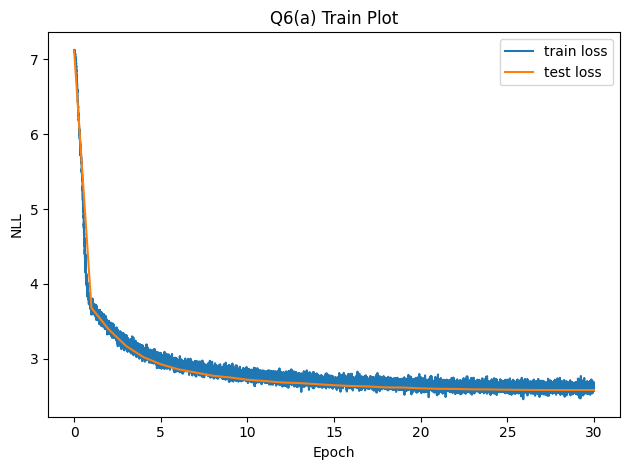

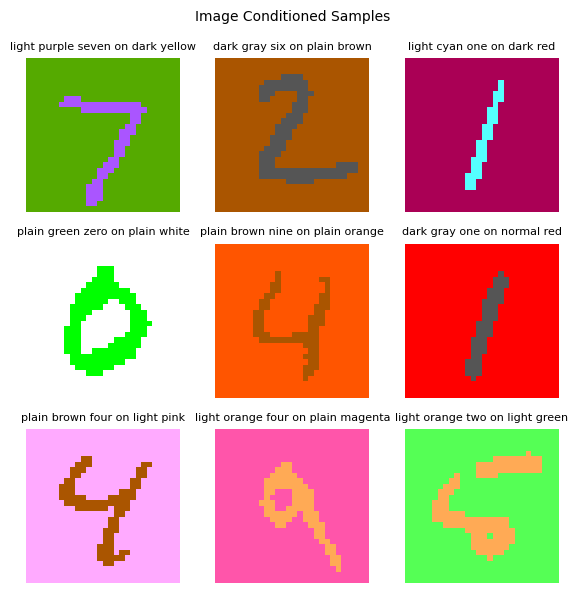

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10..262].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-11..177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9..266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-39..306].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10..259].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10..266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9..266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for fl

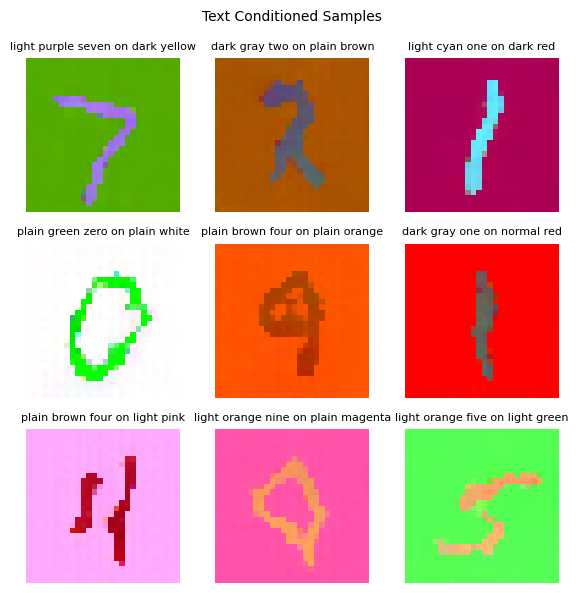

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-27..319].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3..224].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-48..294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9..262].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6..286].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [75..266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-23..286].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floa

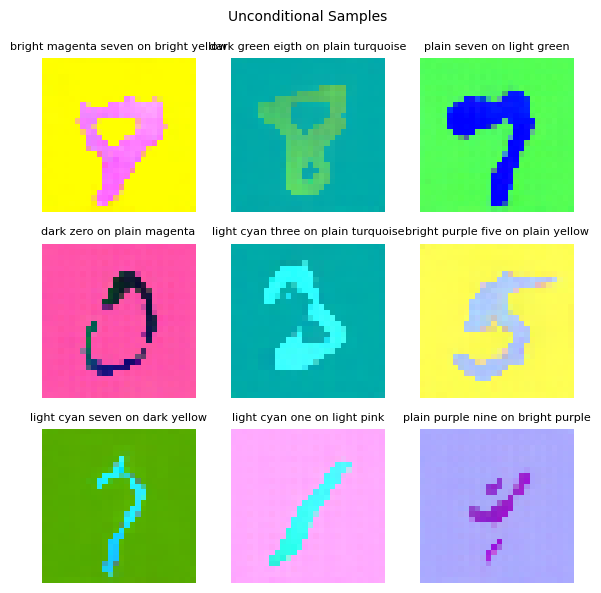

In [35]:
q6a_save_results(q6_a)